# Threshold Analysis ROC

In this note book we will be going through a threshold analysis of one signal and background. 

The general process is as follows:

1. Load histograms of Signal and  for a particular variable of interest.
1. Go to the from the lowest variable value. 
1. Calculate and store the True Positive Rate and False Positive Rate for values above this threshold value.
1. Go to to the next Bin and repeat step 3. until you reach the last bin.
1. Plot the ROC curve and identify the threshold value which maximizes the True Positive Rate but Minimises the False Positive Rate.





### Load the Signal and Background Dataset

In [6]:
#Load packages
import pandas as pd
import json
import matplotlib.pyplot as plt
#import mplhep as hep
import numpy as np

#Sets style for matplotlib
#hep.style.use("CMS")

In [5]:
#Loads in the dataset
df = pd.read_parquet("merged_nominal.parquet")

#Loads in the process names
with open("summary.json", "r") as f:
  proc_dict = json.load(f)["sample_id_map"]

In [7]:
#Creates the background and signal datasets.
background = pd.concat((df[df.process_id == proc_dict["DiPhoton"]],df[df.process_id == proc_dict["TTGG"]],df[df.process_id == proc_dict["TTGamma"]],
                        df[df.process_id == proc_dict["TTJets"]],df[df.process_id == proc_dict["VBFH_M125"]],df[df.process_id == proc_dict["WGamma"]],
                        df[df.process_id == proc_dict["ZGamma"]],df[df.process_id == proc_dict["ggH_M125"]],df[df.process_id == proc_dict["ttH_M125"]],
                        df[df.process_id == proc_dict["GJets"]]), ignore_index=True, axis=0)
signal = df[df.process_id == proc_dict["GluGluToRadionToHHTo2G2Tau_M-1000"]]

## Threshold Analysis on Diphoton Transverse Momentum 

For the purpose of demonstrating this analysis, we will go through a singular attribute, 'Diphoton_pt_mgg'. Firstly, lets visualise this dataset as a histogram.

In [19]:
signal[signal.Diphoton_pt_mgg < i]


,Diphoton_mass,Diphoton_pt_mgg,Diphoton_dPhi,LeadPhoton_pt_mgg,SubleadPhoton_pt_mgg,MET_pt,diphoton_met_dPhi,ditau_met_dPhi,ditau_deta,lead_lepton_pt,...,weight_photon_id_sf_Diphoton_Photon_down,weight_btag_deepjet_sf_SelectedJet_up_lf,weight_muon_id_sfSTAT_SelectedMuon_central,weight_muon_iso_sfSTAT_SelectedMuon_up,weight_central_no_lumi,weight_btag_deepjet_sf_SelectedJet_up_cferr2,weight_btag_deepjet_sf_SelectedJet_up_lfstats2,weight_muon_iso_sfSYS_SelectedMuon_up,weight_tau_idDeepTauVSjet_sf_AnalysisTau_central,weight_L1_prefiring_sf_central
870325,665.341187,0.233535,-2.892560,0.517960,0.306427,159.682419,-2.847426,0.114838,0.610352,40.526459,...,0.962730,0.939456,1.000000,1.000000,0.000017,0.927979,0.971387,1.000000,0.867371,1.0
870326,125.158852,3.885264,0.429626,2.885468,1.071451,274.947449,-3.136589,0.017630,0.688721,64.565208,...,0.986291,0.939456,1.000000,1.000000,0.000019,0.927979,0.971387,1.000000,0.937022,1.0
870327,298.579071,0.165413,2.807862,0.442775,0.338816,69.575775,-0.996858,-9.000000,-9.000000,27.479475,...,0.963702,0.939456,1.000000,1.000000,0.000017,0.927979,0.971387,1.000000,0.925269,1.0
870328,124.978798,3.874058,-0.346191,2.909100,1.009682,54.604580,-0.415355,-9.000000,-9.000000,485.856720,...,0.992761,0.939456,1.000000,1.000000,0.000018,0.927979,0.971387,1.000000,0.867371,1.0
870329,123.804016,3.195039,-0.611816,2.505208,0.801922,342.774506,-2.652684,-9.000000,-9.000000,161.307297,...,0.984498,0.889553,1.000000,1.000000,0.000016,0.878686,0.887508,1.000000,0.867371,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990170,124.464500,3.842689,0.436506,2.753392,1.166912,441.434326,2.903713,-9.000000,-9.000000,23.474821,...,0.961001,0.911331,1.000000,1.000000,0.000008,0.897421,0.906242,1.000000,0.883856,1.0
990171,125.264160,3.712491,-0.603271,2.943995,0.891218,44.370071,-2.823280,-0.394159,0.567383,148.591721,...,1.027231,0.871309,1.000000,1.000000,0.000007,0.858010,0.875540,1.000000,0.932038,1.0
990172,126.484589,0.298251,-2.553223,0.537002,0.435478,38.985405,-2.981734,-9.000000,-9.000000,25.316896,...,0.929435,1.104777,1.000000,1.000000,0.000009,1.116515,1.114388,1.000000,0.888209,1.0
990173,124.973976,3.731749,-0.513654,2.665460,1.172873,196.267242,-2.980060,-0.179958,-0.414001,189.951279,...,0.961001,0.948445,0.999557,0.999892,0.000008,0.933968,0.973269,0.999871,0.932038,1.0


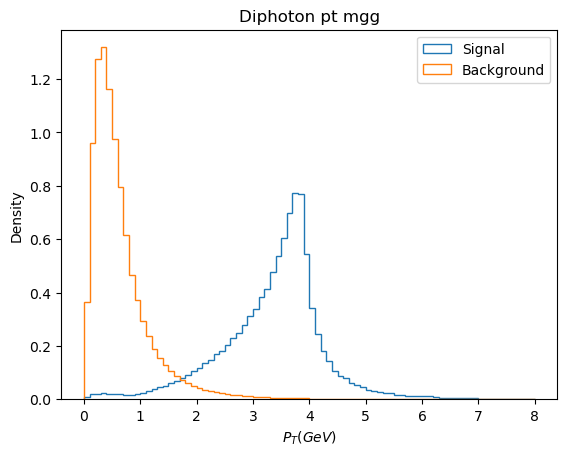

In [12]:
plt.hist(signal.Diphoton_pt_mgg, bins=80, range=(0, 8), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_pt_mgg, bins=80, range=(0, 8), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$P_T (GeV)$")
plt.ylabel(r'Density')
plt.title('Diphoton pt mgg')
plt.savefig("Histogram/Diphoton_pt_mgg.pdf", format="pdf", bbox_inches="tight")
plt.show()

We can see that these two distributions peak at different locations, which suggests that the threshold value we should find to be the most efficent at separating this dataset lies where the datasets intercept. Hopefully the ROC curve analysis leads to the same conclusion...

The next step is to select the first bin edge and count how many values there is to the right of the value for both distributions...

In [23]:
#Get the bin edges
hist_signal, bin_edges_signal = np.histogram(signal.Diphoton_pt_mgg, bins=80, range=(0, 8))
hist_background, bin_edges_background = np.histogram(background.Diphoton_pt_mgg, bins=80, range=(0, 8))
print(bin_edges_signal)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8. ]


In [25]:
#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (1000 steps)
step_number = 1000
step_size = (maximum_edge - minimum_edge)/step_number


8.0


The graph below shows how the histogram is split up in relation to the threshold value. (Assuming everything to the right of the threshold value is a signal.)

![image info](./Pictures\ROC_Explaination.png)

We are interested in two values - True positive rate (TPR) and False positive rate (FPR); which will enable us to plot ROC curves

The formula for these values are :-
* TPR = TP/(TP + FN)
* FPR = FP/(FP + TN)

These are the values we will calculate for each threshold value.

In [15]:
signal_feature_arr = signal.Diphoton_pt_mgg.to_numpy()
background_feature_arr = background.Diphoton_pt_mgg.to_numpy()

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
while i < (maximum_edge+step_size):
    i += step_size
    TP = len(signal_feature_arr[(signal_feature_arr>=i)])
    FP = len(background_feature_arr[(background_feature_arr>=i)])
    FN = len(signal_feature_arr[(signal_feature_arr<i)])
    TN = len(background_feature_arr[(background_feature_arr<i)])
    print(FP)
    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)




765663
765050
764032
762700
760983
758911
756670
753934
750854
747485
743876
739956
735729
731043
726218
721207
715908
710186
704194
698086
691754
685197
678556
671646
664403
657097
649776
642425
634776
627091
619298
611258
603233
595153
586985
578867
570861
562638
554403
546171
537994
529775
521544
513478
505240
497226
489206
481335
473604
465735
458134
450505
442985
435628
428375
421118
414057
406951
400032
393261
386524
379946
373320
366996
360602
354354
348215
342193
336075
330068
324202
318403
312855
307288
301905
296479
291081
285808
280606
275679
270878
266096
261345
256638
252021
247519
243038
238808
234503
230332
226246
222343
218478
214759
211064
207432
204027
200664
197276
193905
190640
187560
184465
181410
178419
175437
172604
169833
167139
164483
161835
159318
156852
154368
151932
149551
147145
144863
142545
140378
138157
135942
133798
131733
129638
127681
125667
123726
121745
119871
118108
116383
114628
112888
111188
109492
107841
106187
104569
103012
101507
99998
98485
9

Below shows a plot of the ROC curve for this variable, each point refers to the TPR and FPR at each threshold value.

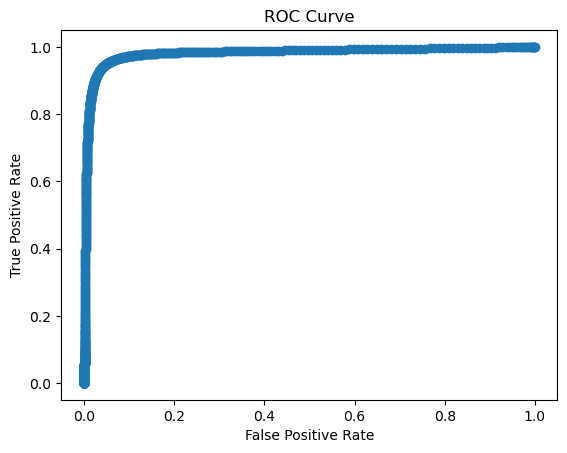

In [16]:
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

We see that at some point increasing the TPR results in a large increase in the FPR. We want the threshold value which maximises the TPR but minimises the FPR, which is the turning point of this graph. To get this value, below we plot a graph of the threshold value vs the difference of the TPR and FPR; therefore the larger the difference the better the threshold performs at separating the signal from the background.

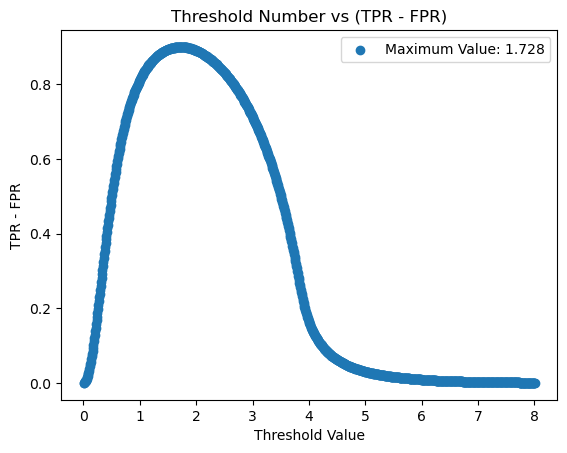

In [17]:

diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR)')
plt.show()


We see that the threshold value which maximises this difference (The biggest TPR and smallest FPR), is 1.728 (GeV). This value is close to 2 (GeV) which we expected to be the approximate most efficient threshold value.

However the counts used to get the number of TP,TN,FN and FP are not entirely accurate as they don't account for the weight of each process, hence don't relate to real data. To account for this in the next section we will sum over the 'weight_central' to account for this, rather than the number of 'entries'.

### Using Weight central

In [18]:
signal_feature_arr = signal.Diphoton_pt_mgg.to_numpy()
background_feature_arr = background.Diphoton_pt_mgg.to_numpy()

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1
while i < (maximum_edge+step_size):
    #print(f'{count}/{int((maximum_edge+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal.Diphoton_pt_mgg >= i].weight_central)
    FP = sum(background[background.Diphoton_pt_mgg >= i].weight_central)
    FN = sum(signal[signal.Diphoton_pt_mgg < i].weight_central)
    TN = sum(background[background.Diphoton_pt_mgg < i].weight_central)
    #print(signal[signal.Diphoton_pt_mgg < i])
    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

The ROC curve using weight central

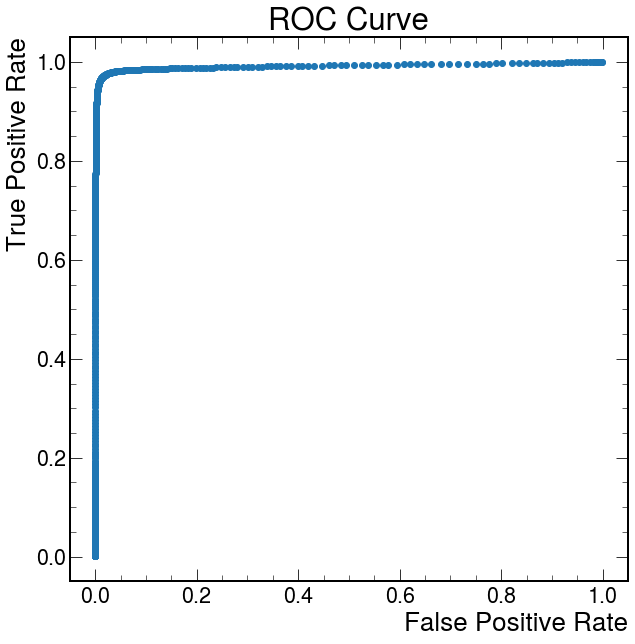

In [60]:
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.show()

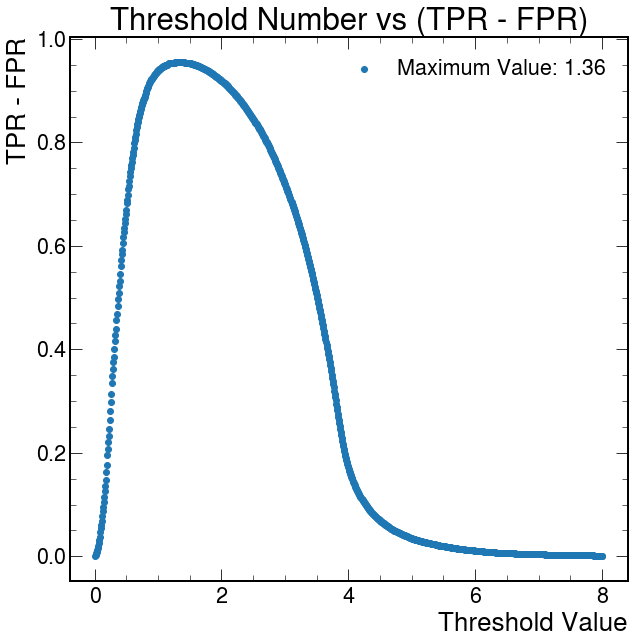

In [61]:

diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR)')
plt.show()


As seen, using weight central influences where our threshold lies. As weight central corrects our simulated dataset, this threshold value is the better value to use for a real dataset.

## Applying Analysis To All Features

In this section, we will be applying this analysis to all the other features in the dataset. (Applying the weights)

The features we will be exploring are: 'Diphoton_mass', 'Diphoton_pt_mgg', 'Diphoton_dPhi',
       'LeadPhoton_pt_mgg', 'SubleadPhoton_pt_mgg', 'MET_pt',
       'diphoton_met_dPhi', 'ditau_met_dPhi', 'ditau_deta', 'lead_lepton_pt',
       'lead_lepton_mass', 'jet_1_pt', 'ditau_pt', 'ditau_mass',
       'ditau_dR', 'ditau_dphi', 'Diphoton_ditau_dphi', 'dilep_leadpho_mass', 'reco_MX_mgg',
       'Diphoton_ditau_deta', 'Diphoton_lead_lepton_deta',
       'Diphoton_lead_lepton_dR', 'Diphoton_sublead_lepton_deta',
       'Diphoton_sublead_lepton_dR', 'LeadPhoton_ditau_dR',
       'LeadPhoton_lead_lepton_dR', 'SubleadPhoton_lead_lepton_dR'.

### Diphoton_mass

#### Visualising the Dataset - 

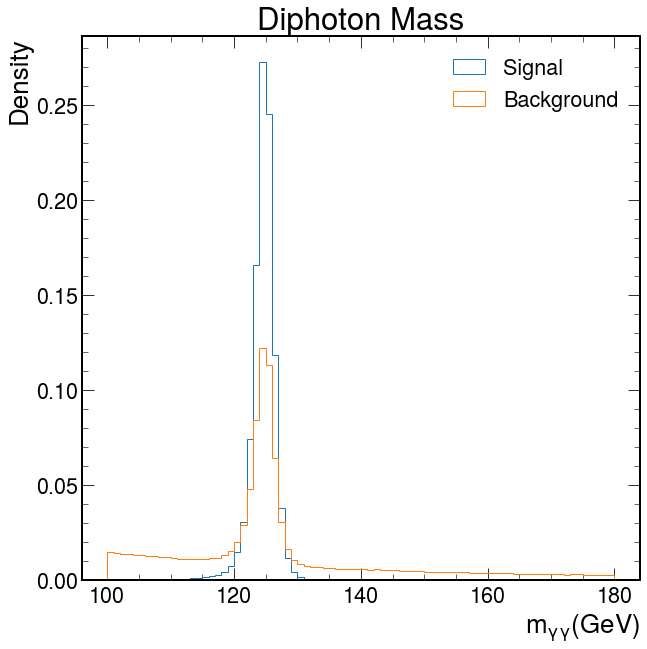

In [73]:
plt.hist(signal.Diphoton_mass, range=(100, 180), bins=80, histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_mass, range=(100, 180), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$m_{\gamma\gamma} (GeV)$")
plt.ylabel(r'Density')
plt.title('Diphoton Mass')
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


FileNotFoundError: [Errno 2] No such file or directory: 'ROC_Curves_Threshold/Diphoton_mass.pdf'

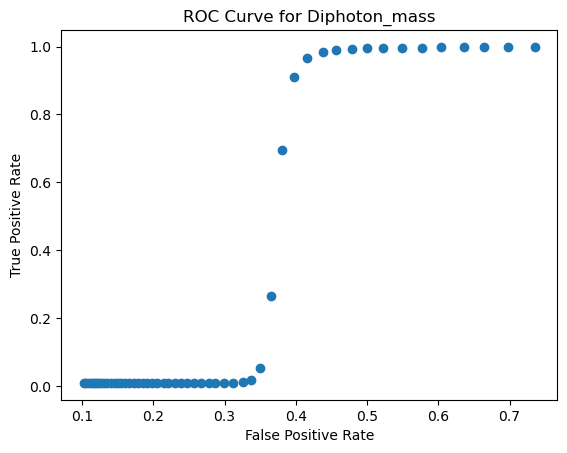

In [27]:
name = 'Diphoton_mass'

hist_signal, bin_edges_signal = np.histogram(signal[name], range=(100, 180), bins=80)
hist_background, bin_edges_background = np.histogram(background[name], range=(100, 180), bins=80)

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Diphoton_dPhi

#### Visualising the Dataset - 

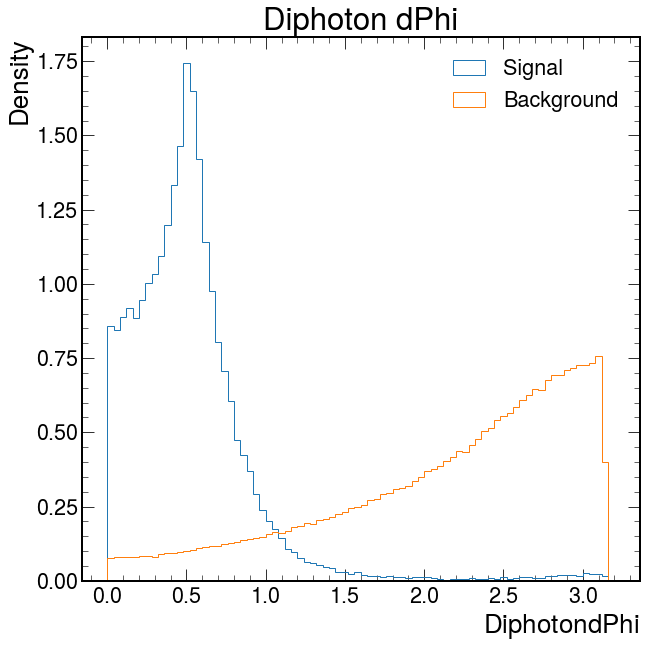

In [79]:
plt.hist(signal.Diphoton_dPhi, bins=80, range=(0, 3.2), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_dPhi, bins=80, range=(0, 3.2), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$Diphoton dPhi$")
plt.ylabel(r'Density')
plt.title('Diphoton dPhi')
plt.savefig("Histogram/Diphoton_dPhi.pdf", format="pdf", bbox_inches="tight")
plt.show()

We see that the signal peaks before the background in this distribution, this means that the value for the TPR will decrease faster than the FPR, leading to a roc curve which may seemed to be 'flipped'. Therefore rather than select everything to the right of the threshold value as being the signal, we will choose everything to the left.

#### Analysis

10/51
20/51
30/51
40/51
50/51


FileNotFoundError: [Errno 2] No such file or directory: 'ROC_Curves_Threshold/Diphoton_dPhi.pdf'

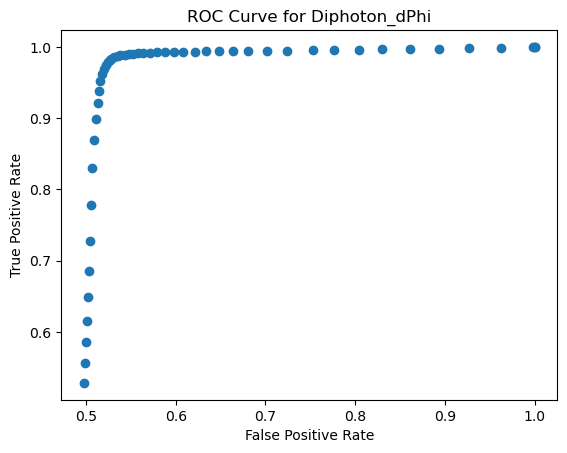

In [28]:
name = 'Diphoton_dPhi'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 3.2))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 3.2))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    if count%10 ==0:
        print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
min_value = min(diff)
index_ = np.where(diff == min_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Minimum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

We see that there is a strong ROC curve, with the best threshold value for signal being <=3.2

### LeadPhoton_pt_mgg

#### Visualising the Dataset - 

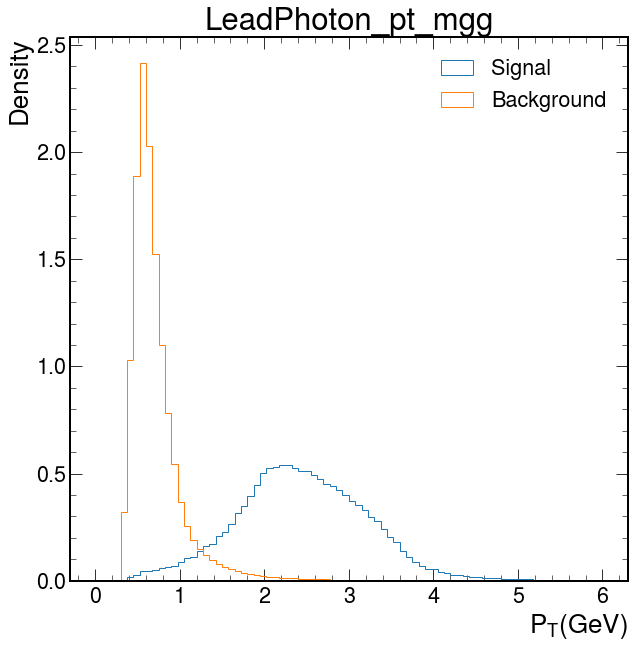

In [84]:
plt.hist(signal.LeadPhoton_pt_mgg, bins=80, range=(0, 6), histtype="step", label="Signal", density = True)
plt.hist(background.LeadPhoton_pt_mgg, bins=80, range=(0, 6), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$P_T (GeV)$")
plt.ylabel(r'Density')
plt.title('LeadPhoton_pt_mgg')
plt.savefig("Histogram/LeadPhoton_pt_mgg.pdf", format="pdf", bbox_inches="tight")
plt.show()

As the signal peak occurs after the signal we can take values above the threshold as the positive (the signal).

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


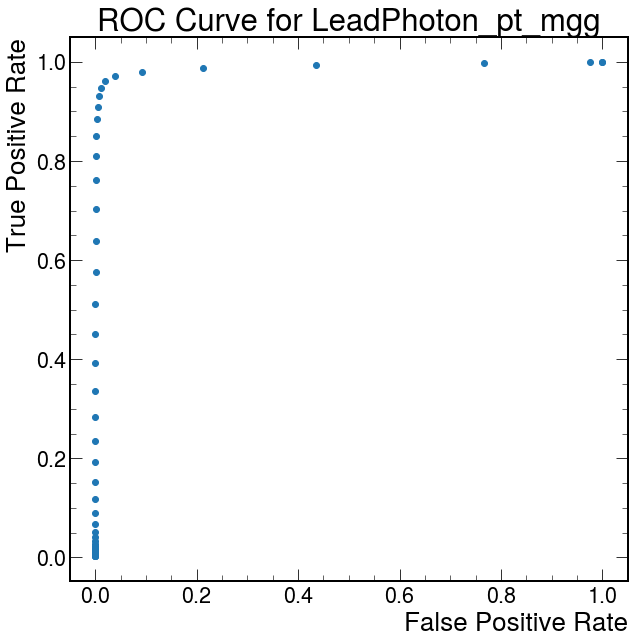

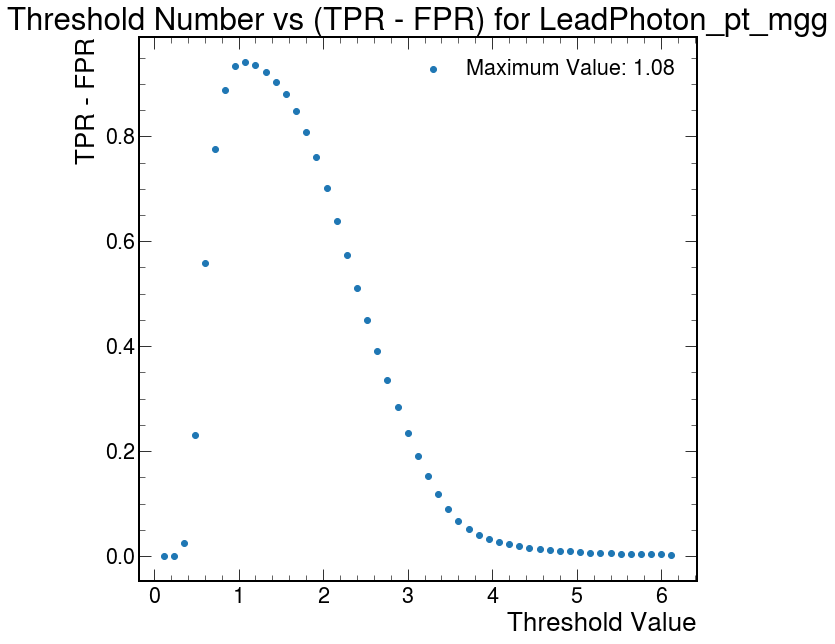

In [85]:
name = 'LeadPhoton_pt_mgg'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 6))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 6))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

Suggests that 1.08 <=  is a good indicator for signal.

### SubleadPhoton_pt_mgg

#### Visualising the Dataset - 

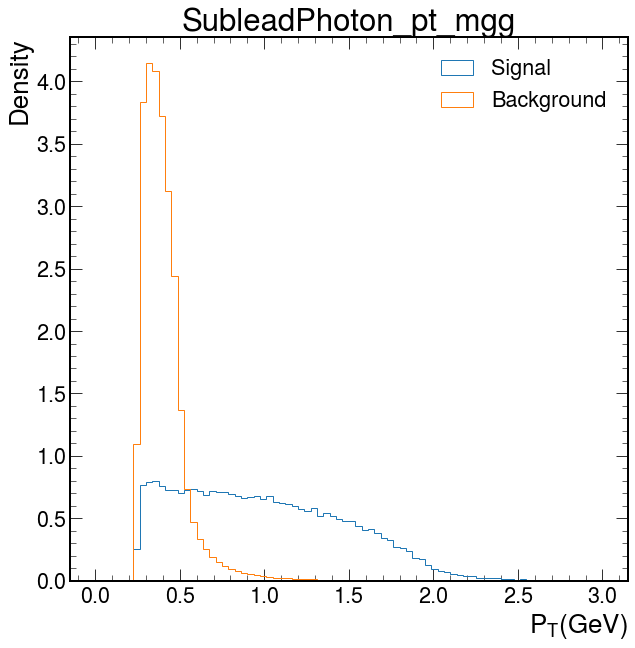

In [87]:
plt.hist(signal.SubleadPhoton_pt_mgg, bins=80, range=(0, 3), histtype="step", label="Signal", density = True)
plt.hist(background.SubleadPhoton_pt_mgg, bins=80, range=(0, 3), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$P_T(GeV)$")
plt.ylabel(r'Density')
plt.title('SubleadPhoton_pt_mgg')
plt.savefig("Histogram/SubleadPhoton_pt_mgg.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


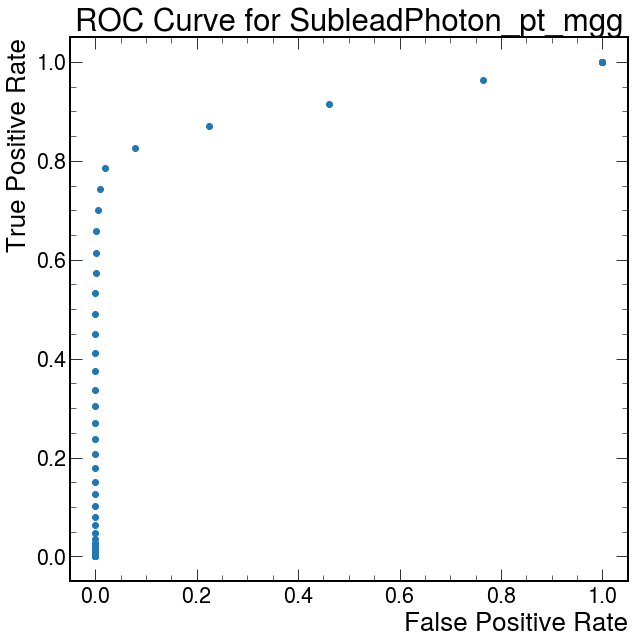

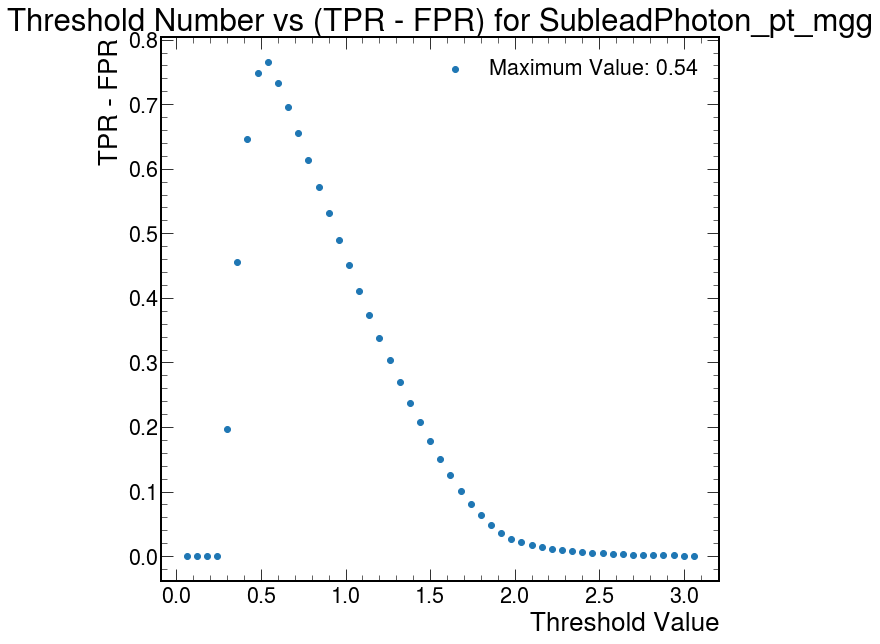

In [88]:
name = 'SubleadPhoton_pt_mgg'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 3))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 3))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

Suggest the best threshold for signal is 0.54 <= 

### MET_pt

#### Visualising the Dataset - 

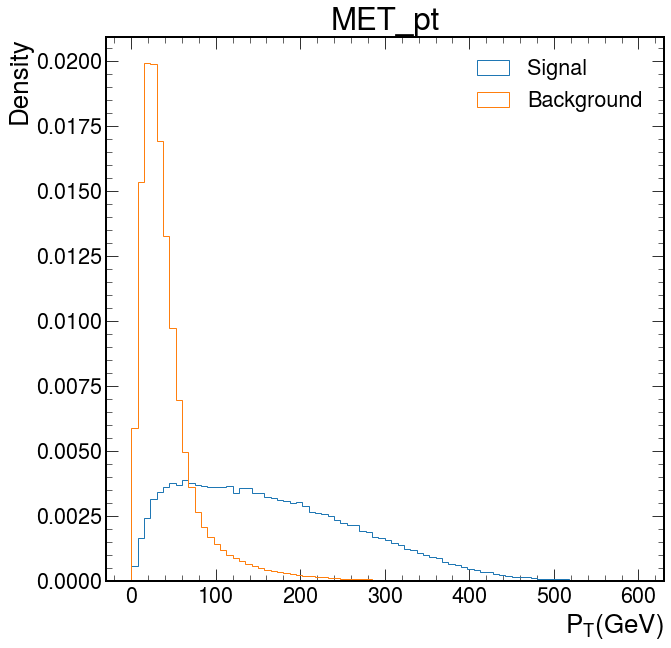

In [89]:
plt.hist(signal.MET_pt, bins=80, range=(0, 600), histtype="step", label="Signal", density = True)
plt.hist(background.MET_pt, bins=80, range=(0, 600), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$P_T (GeV)$")
plt.ylabel(r'Density')
plt.title('MET_pt')
plt.savefig("Histogram/MET_pt.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


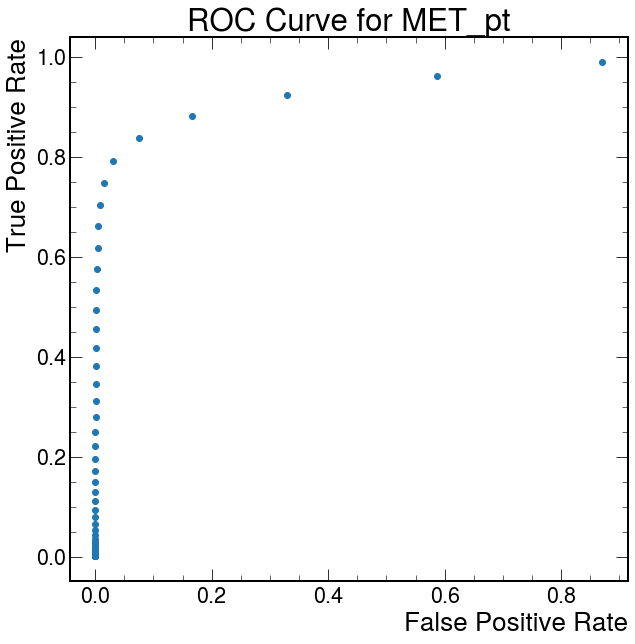

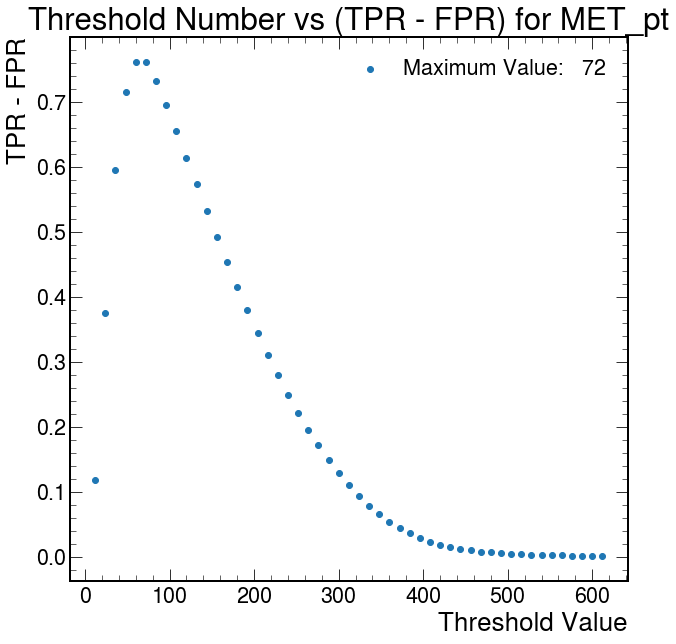

In [90]:
name = 'MET_pt'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 600))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 600))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Diphoton_met_dPhi

#### Visualising the Dataset - 

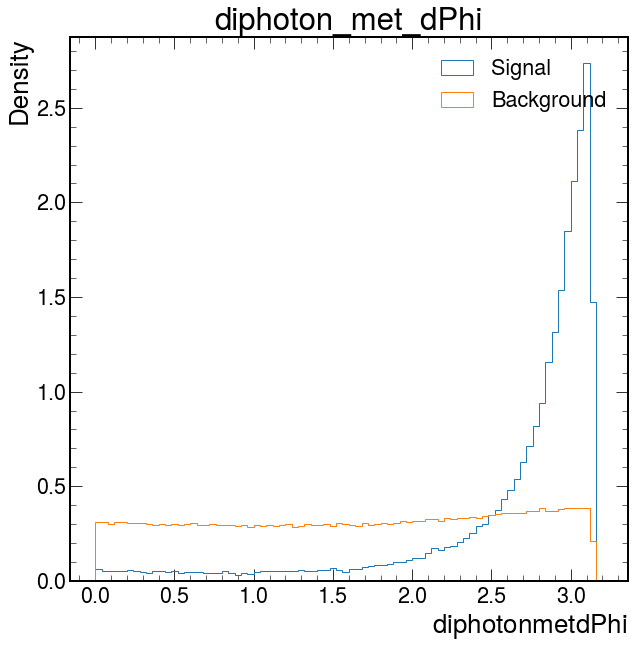

In [93]:
plt.hist(signal.diphoton_met_dPhi, bins=80, range=(0, 3.2), histtype="step", label="Signal", density = True)
plt.hist(background.diphoton_met_dPhi, bins=80, range=(0, 3.2), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$diphoton met dPhi$")
plt.ylabel(r'Density')
plt.title('diphoton_met_dPhi')
plt.savefig("Histogram/diphoton_met_dPhi.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


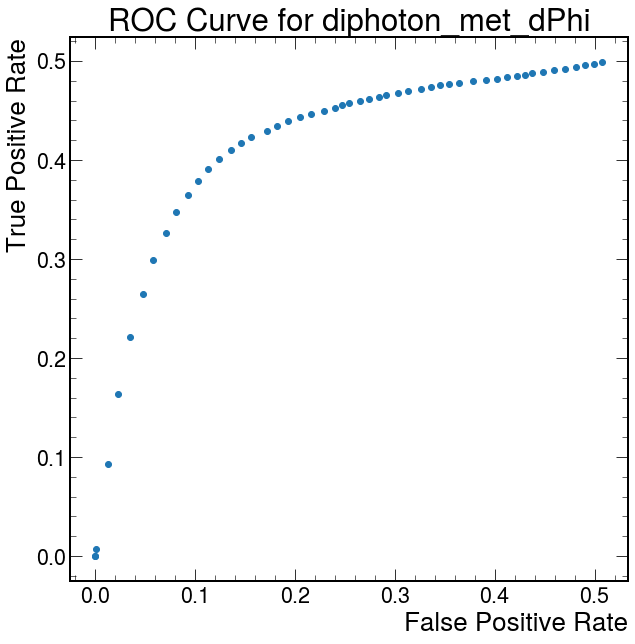

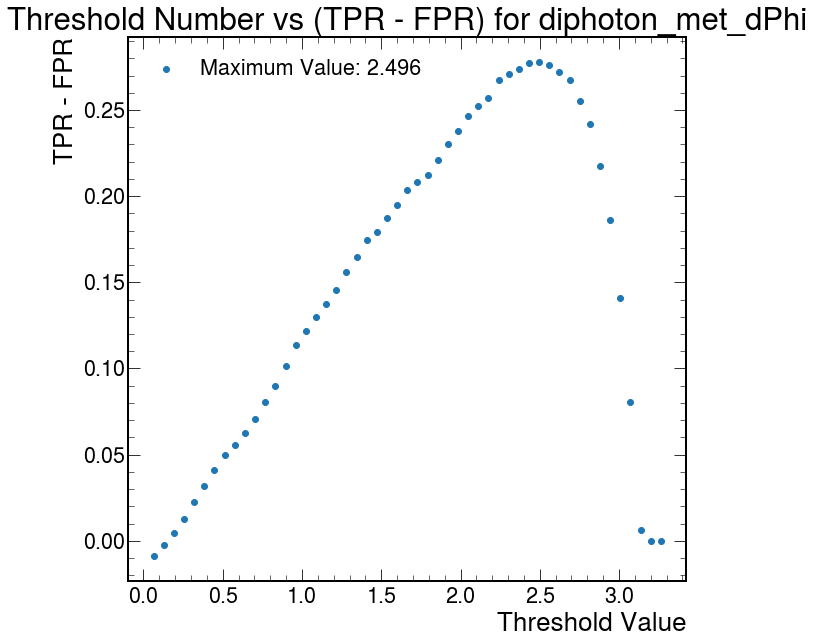

In [94]:
name = 'diphoton_met_dPhi'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 3.2))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 3.2))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### ditau_met_dPhi

#### Data Visualisation - 

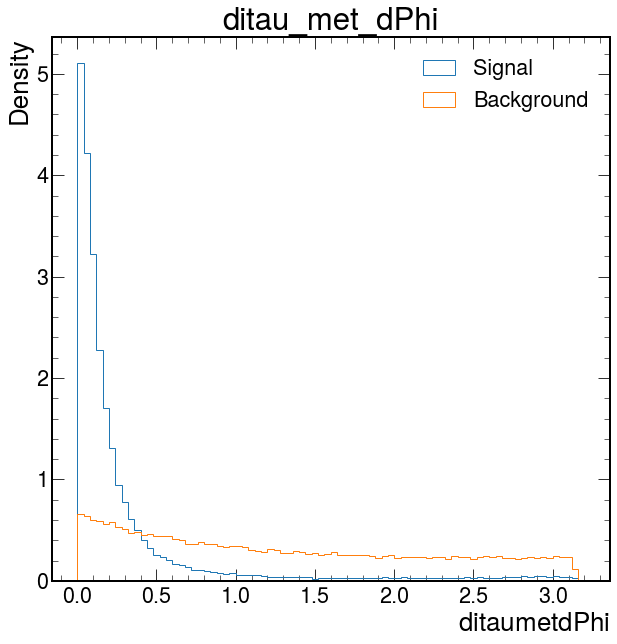

In [97]:
plt.hist(signal.ditau_met_dPhi, bins=80, range=(0, 3.2), histtype="step", label="Signal", density = True)
plt.hist(background.ditau_met_dPhi, bins=80, range=(0, 3.2), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$ditau met dPhi$")
plt.ylabel(r'Density')
plt.title('ditau_met_dPhi')
plt.savefig("Histogram/ditau_met_dPhi.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


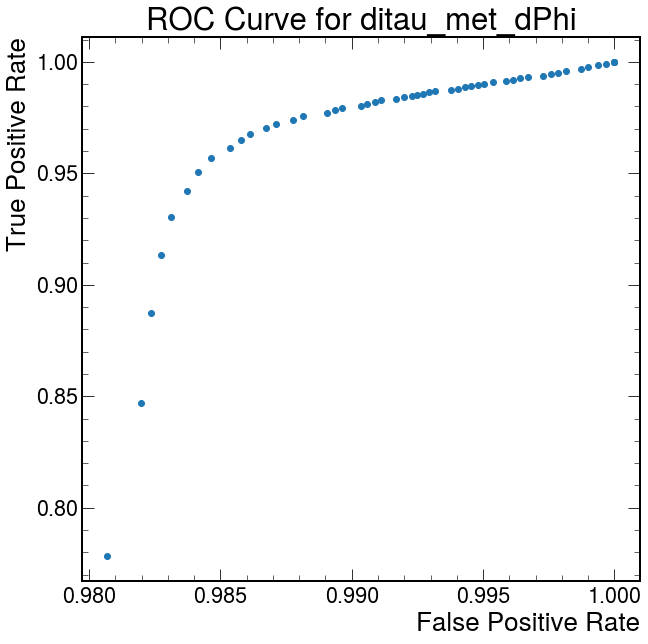

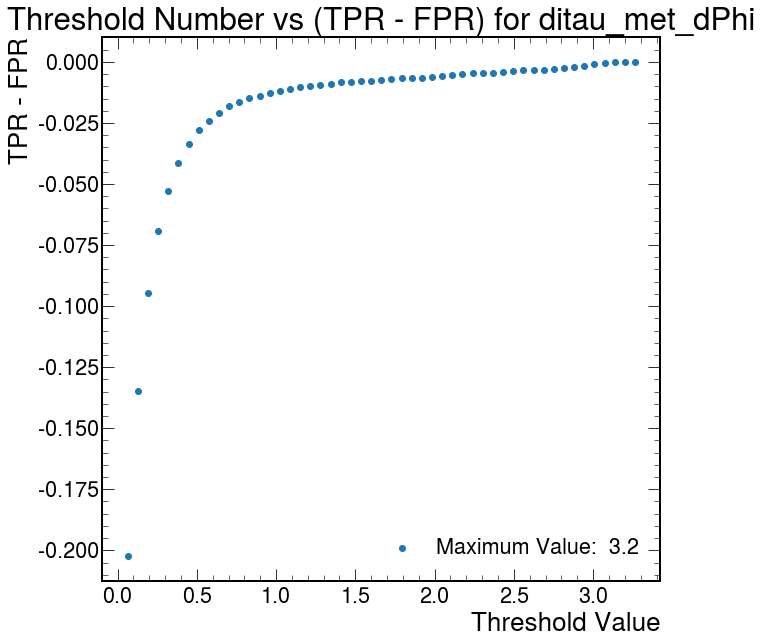

In [98]:
name = 'ditau_met_dPhi'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 3.2))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 3.2))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### ditau_deta

#### Data Visualisation

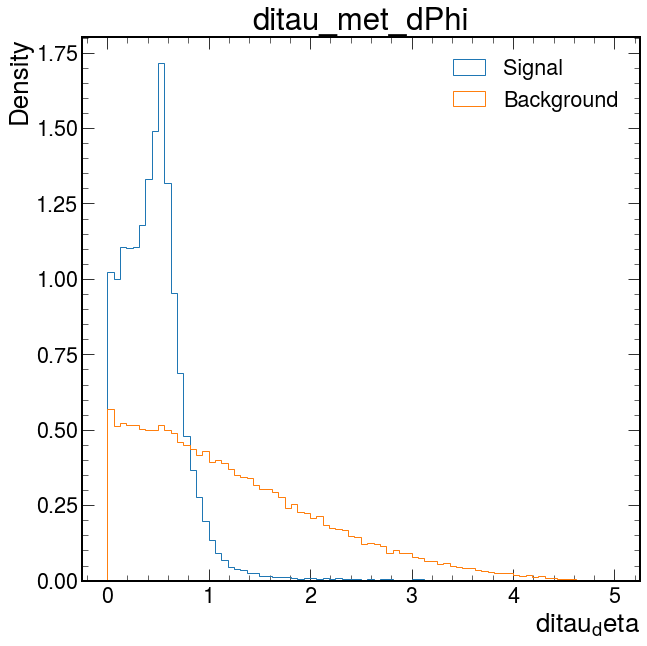

In [100]:
plt.hist(signal.ditau_deta, bins=80, range=(0, 5), histtype="step", label="Signal", density = True)
plt.hist(background.ditau_deta, bins=80, range=(0, 5), histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$ditau_deta$")
plt.ylabel(r'Density')
plt.title('ditau_met_dPhi')
plt.savefig("Histogram/ditau_met_dPhi.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


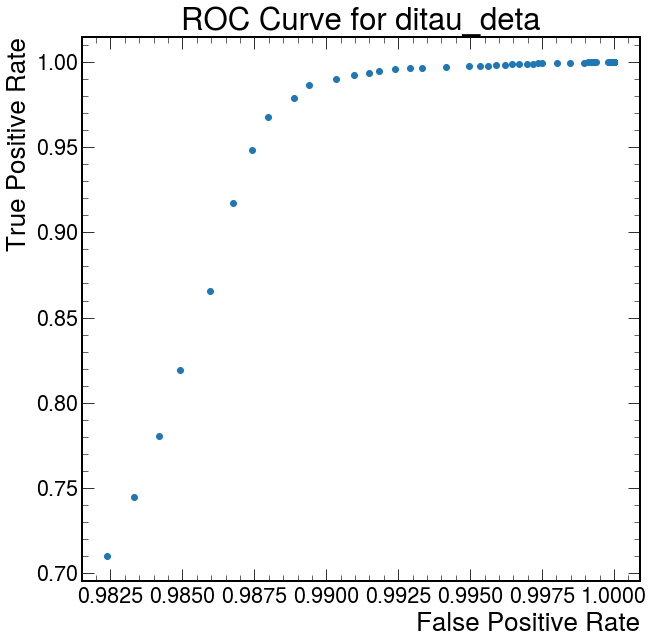

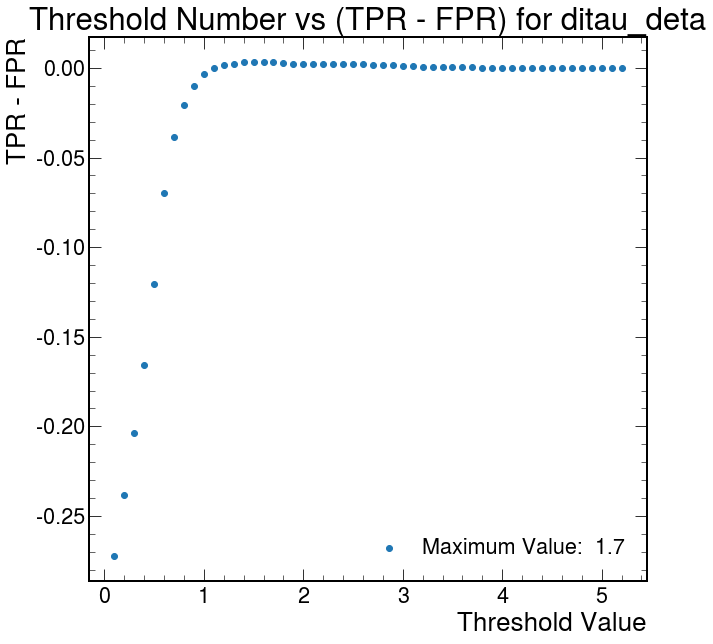

In [101]:
name = 'ditau_deta'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 5))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 5))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### lead_lepton_pt

#### Data Visualisation

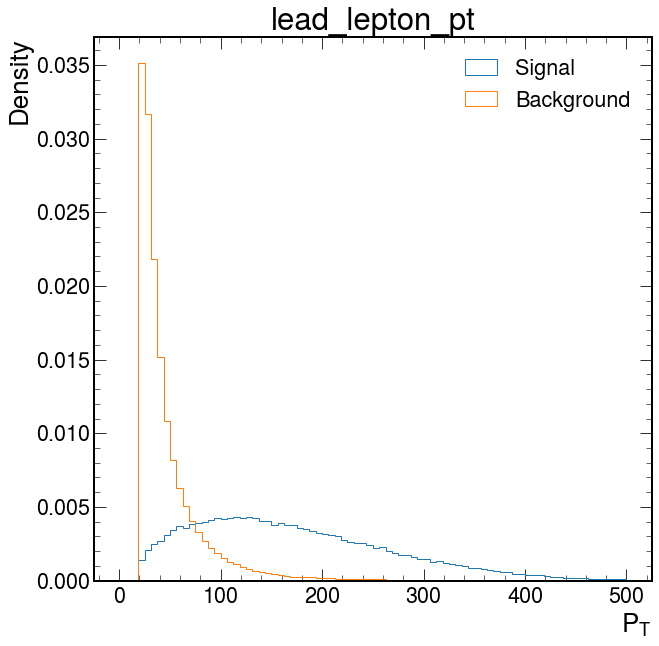

In [103]:
plt.hist(signal.lead_lepton_pt, bins=80, range=(0, 500), histtype="step", label="Signal", density = True)
plt.hist(background.lead_lepton_pt, range=(0, 500), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$P_T$")
plt.ylabel(r'Density')
plt.title('lead_lepton_pt')
plt.savefig("Histogram/lead_lepton_pt.pdf", format="pdf", bbox_inches="tight")
plt.show()

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


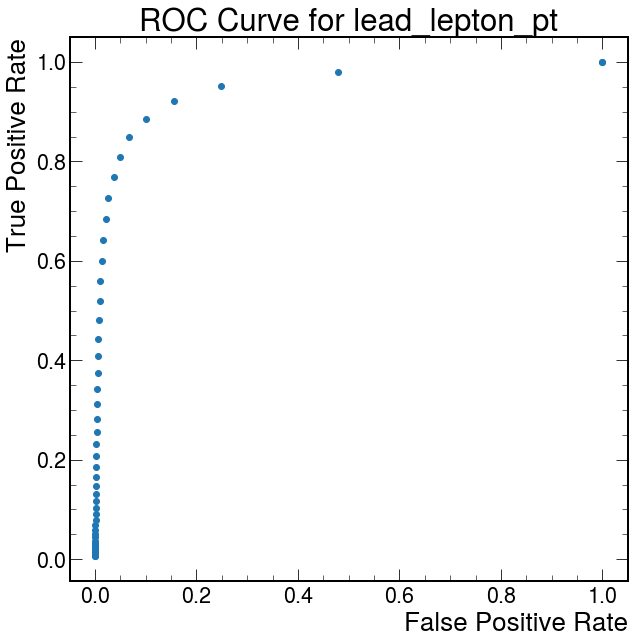

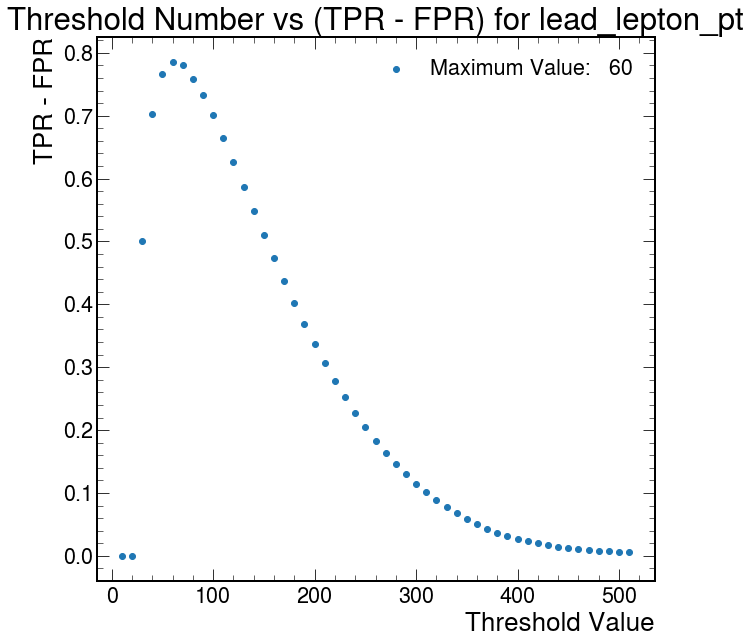

In [105]:
name = 'lead_lepton_pt'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 500))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 500))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### lead_lepton_mass

#### Data Visualisation

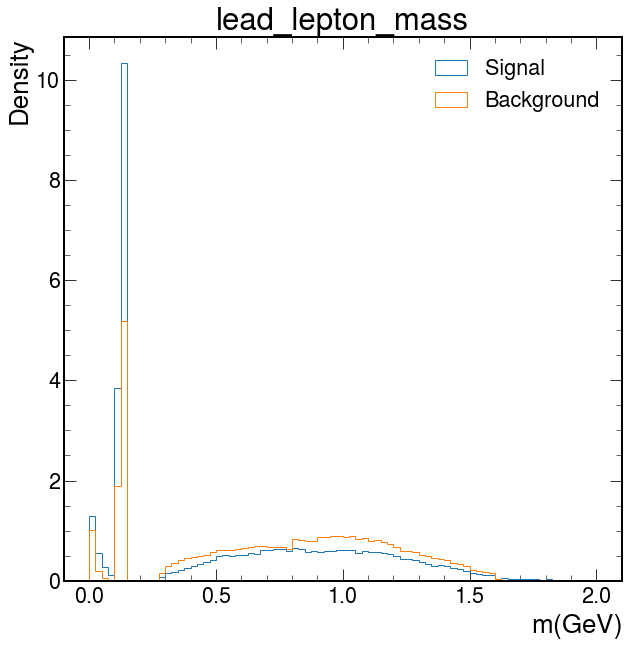

In [107]:
plt.hist(signal.lead_lepton_mass, bins=80, range=(0, 2), histtype="step", label="Signal", density = True)
plt.hist(background.lead_lepton_mass, range=(0, 2), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$m (GeV)$")
plt.ylabel(r'Density')
plt.title('lead_lepton_mass')
plt.savefig("Histogram/lead_lepton_mass.pdf", format="pdf", bbox_inches="tight")
plt.show()

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


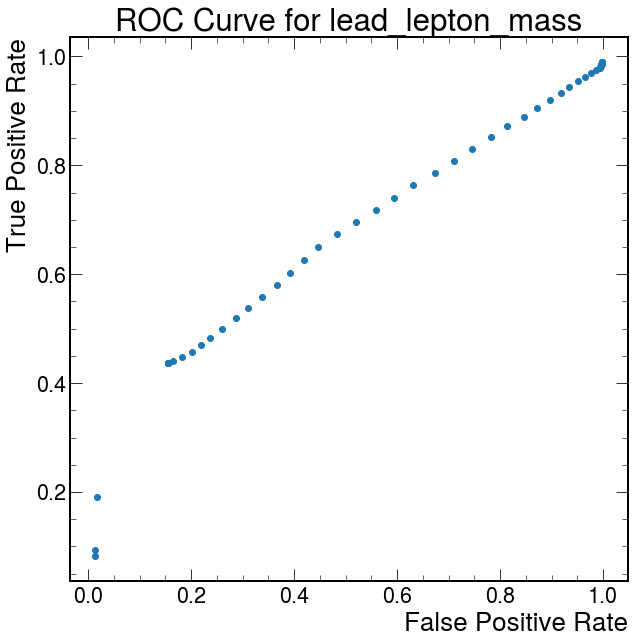

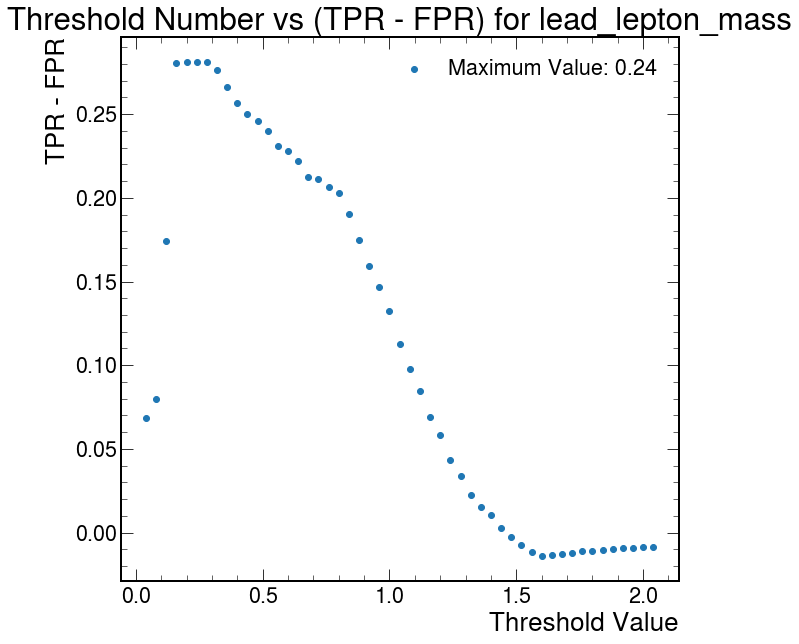

In [108]:
name = 'lead_lepton_mass'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 2))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 2))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### jet_1_pt

#### Data Visualisation

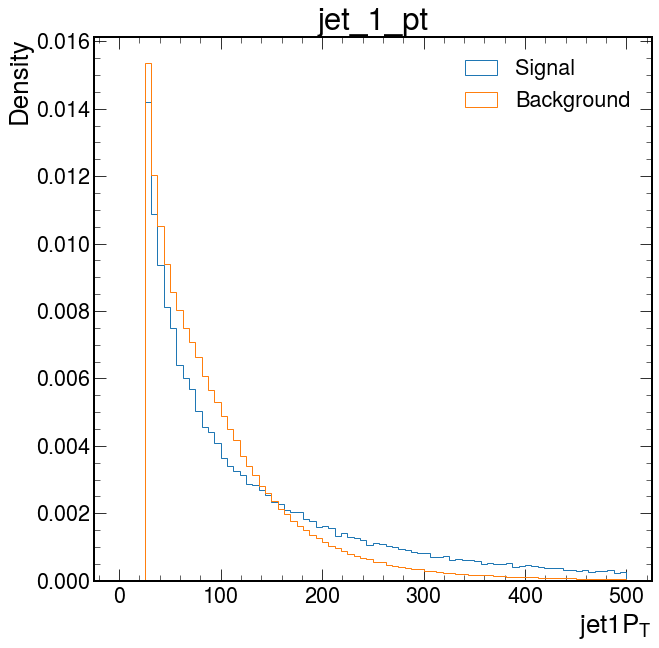

In [110]:
plt.hist(signal.jet_1_pt, bins=80, range=(0, 500), histtype="step", label="Signal", density = True)
plt.hist(background.jet_1_pt, range=(0, 500), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$jet1P_T$")
plt.ylabel(r'Density')
plt.title('jet_1_pt')
plt.savefig("Histogram/jet_1_pt.pdf", format="pdf", bbox_inches="tight")
plt.show()

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


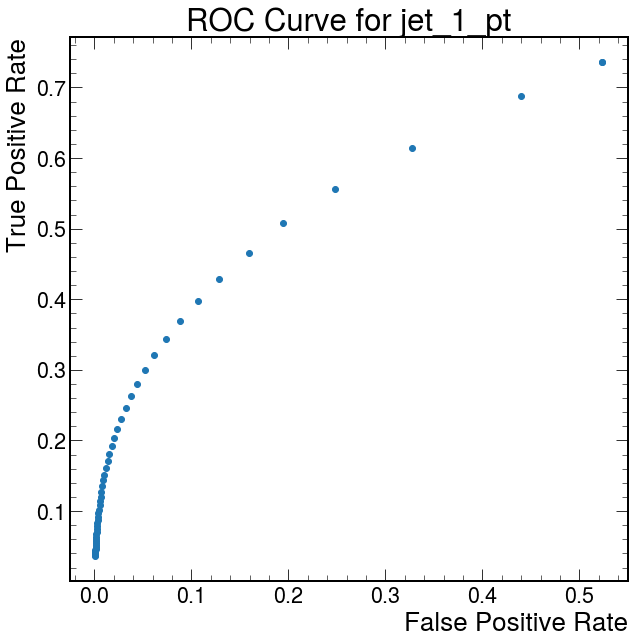

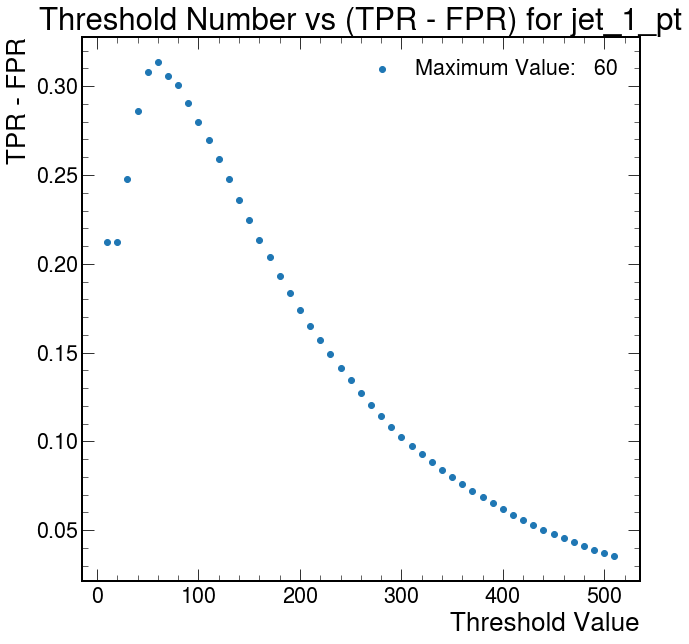

In [112]:
name = 'jet_1_pt'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 500))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 500))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### ditau_pt

#### Data Visualisation

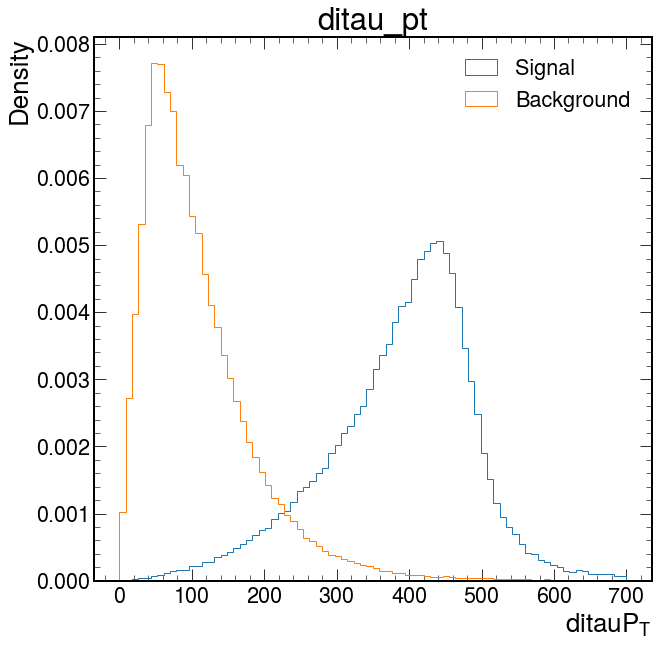

In [114]:
plt.hist(signal.ditau_pt, bins=80, range=(0, 700), histtype="step", label="Signal", density = True)
plt.hist(background.ditau_pt, range=(0, 700), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$ditauP_T$")
plt.ylabel(r'Density')
plt.title('ditau_pt')
plt.savefig("Histogram/ditau_pt.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


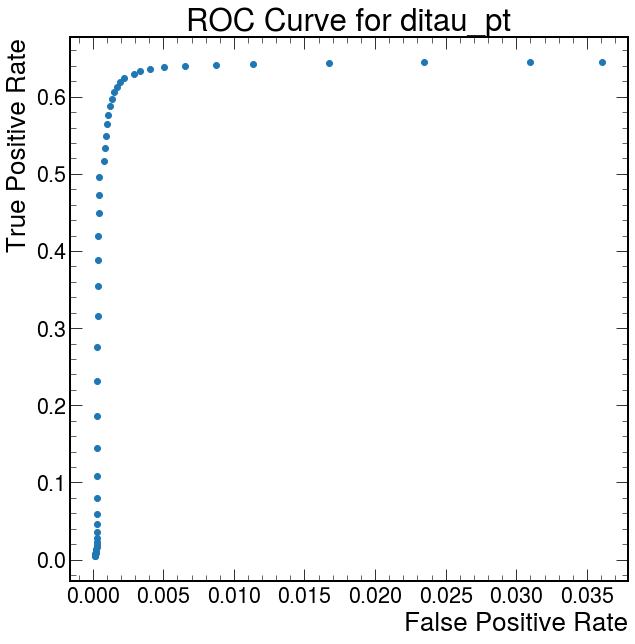

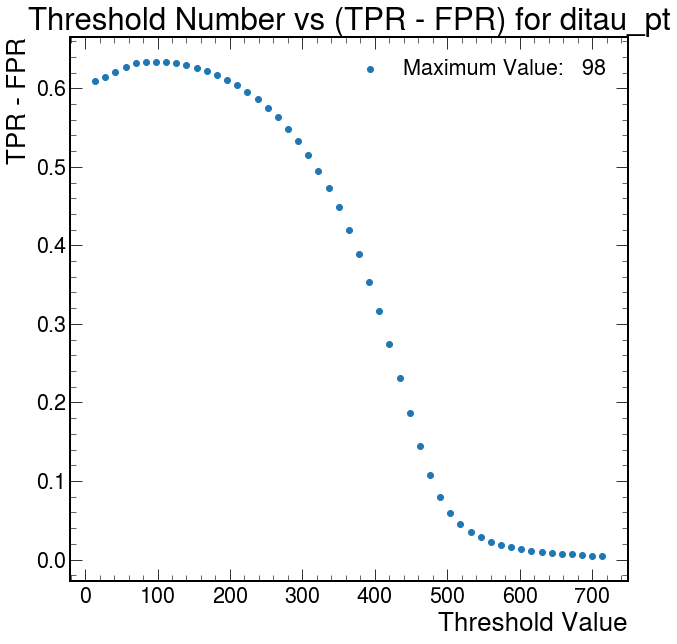

In [115]:
name = 'ditau_pt'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 700))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 700))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### ditau_mass

#### Data Visualisation

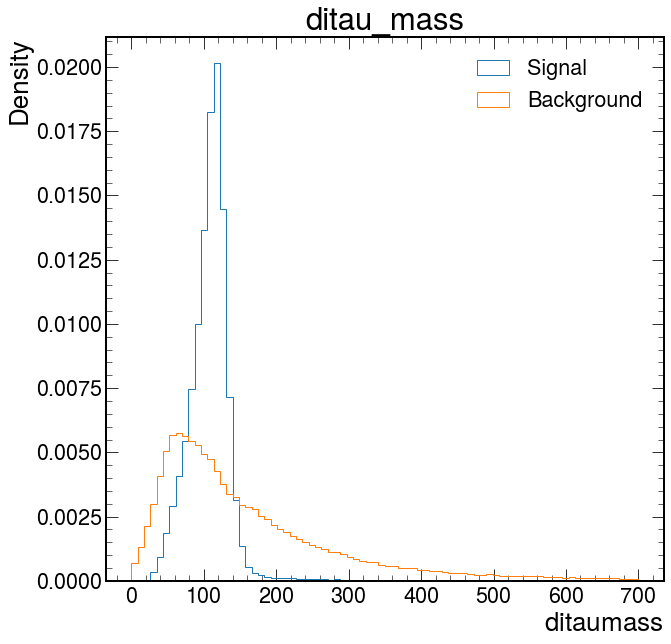

In [118]:
plt.hist(signal.ditau_mass, bins=80, range=(0, 700), histtype="step", label="Signal", density = True)
plt.hist(background.ditau_mass, range=(0, 700), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$ditaumass$")
plt.ylabel(r'Density')
plt.title('ditau_mass')
plt.savefig("Histogram/ditau_mass.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


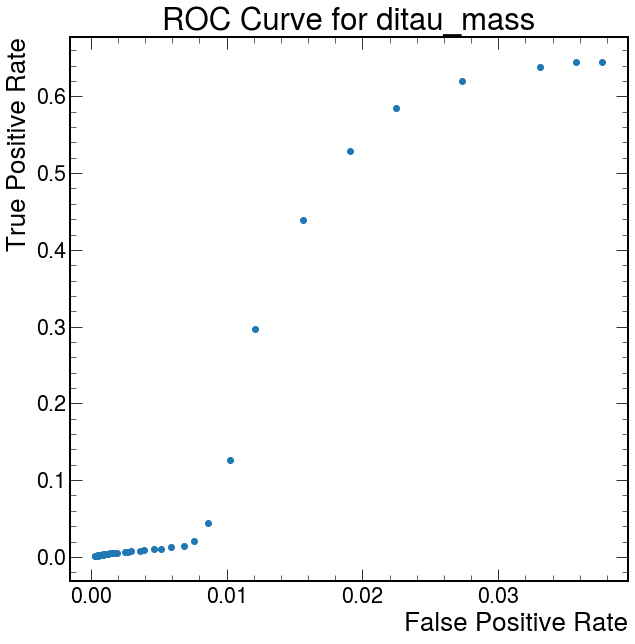

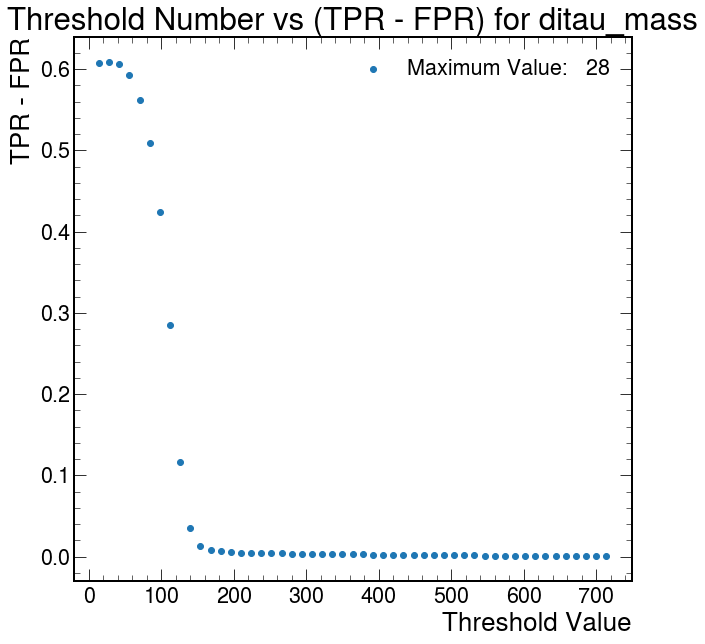

In [119]:
name = 'ditau_mass'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 700))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 700))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### ditau_dR
#### Data Visualisation

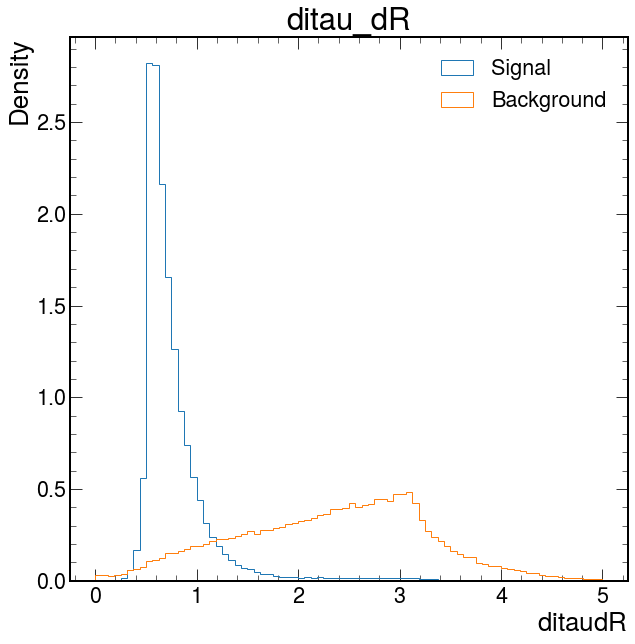

In [121]:
plt.hist(signal.ditau_dR, bins=80, range=(0, 5), histtype="step", label="Signal", density = True)
plt.hist(background.ditau_dR, range=(0, 5), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$ditau dR$")
plt.ylabel(r'Density')
plt.title('ditau_dR')
plt.savefig("Histogram/ditau_dR.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


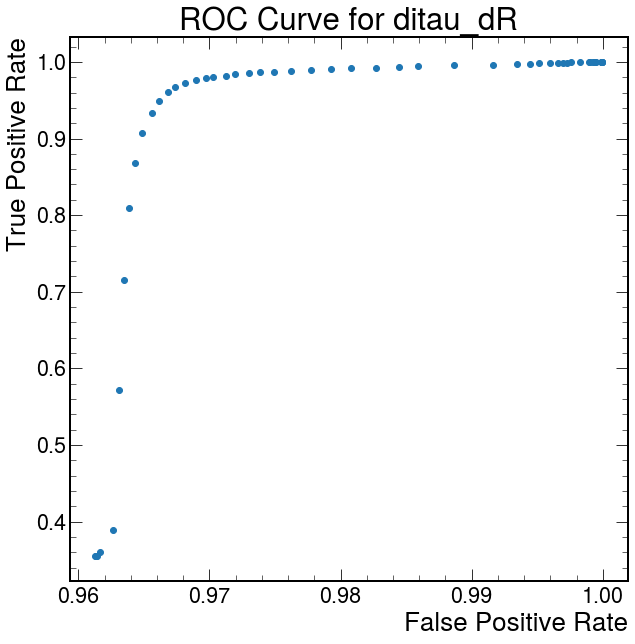

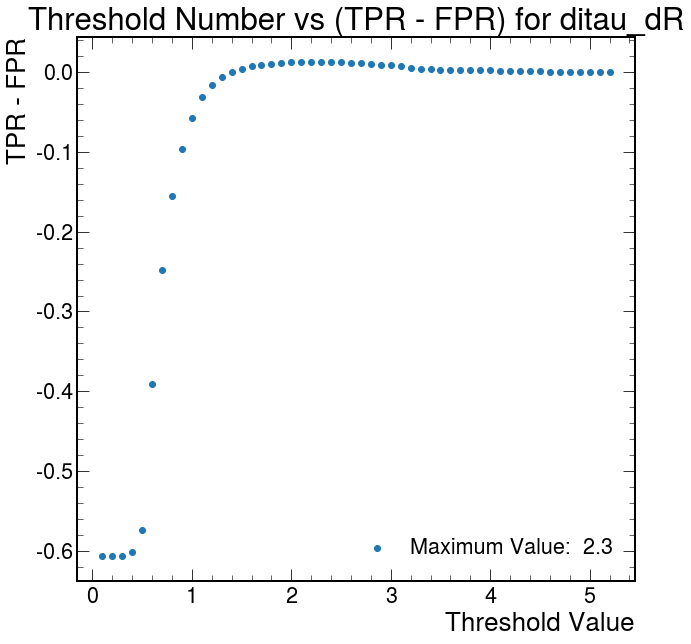

In [122]:
name = 'ditau_dR'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 5))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 5))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### ditau_dphi

#### Data Visualisation

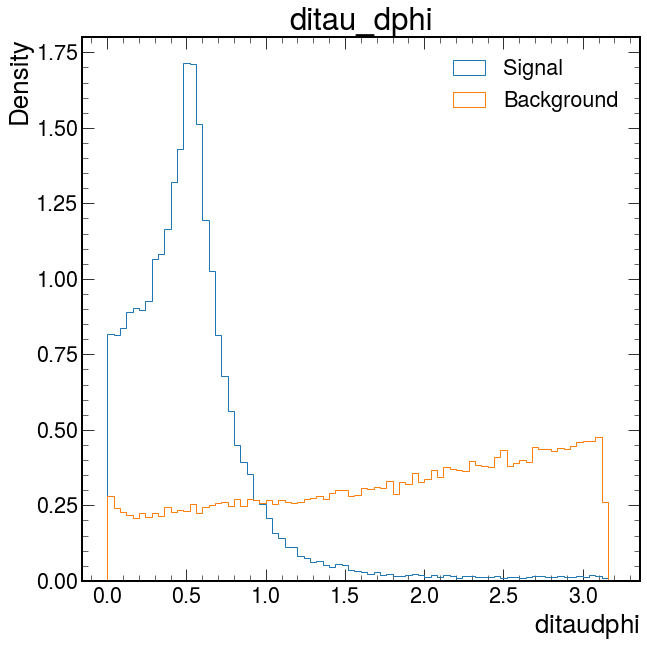

In [124]:
plt.hist(signal.ditau_dphi, bins=80, range=(0, 3.2), histtype="step", label="Signal", density = True)
plt.hist(background.ditau_dphi, range=(0, 3.2), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$ditaudphi$")
plt.ylabel(r'Density')
plt.title('ditau_dphi')
plt.savefig("Histogram/ditau_dphi.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


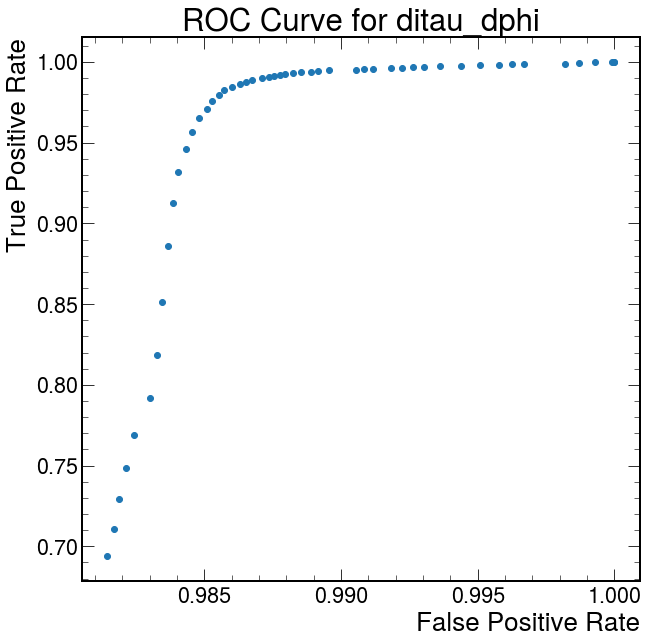

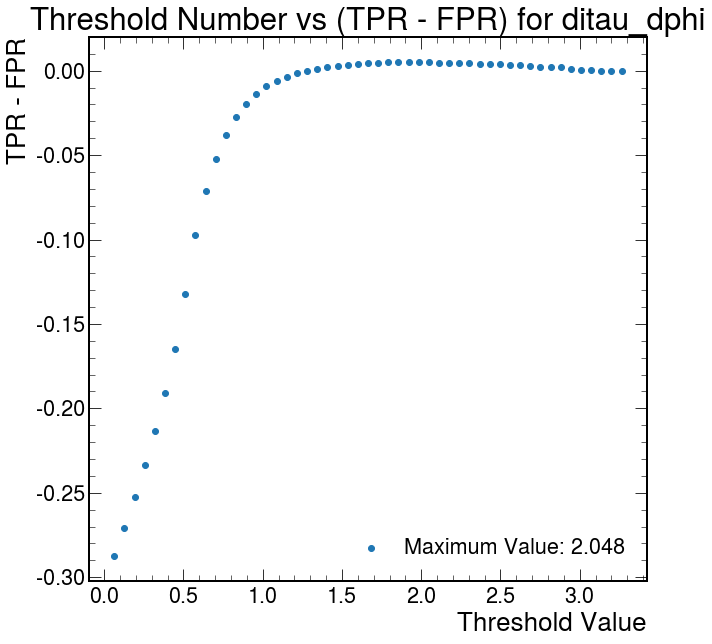

In [125]:
name = 'ditau_dphi'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 3.2))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 3.2))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Diphoton_ditau_dphi

#### Data Visualisation

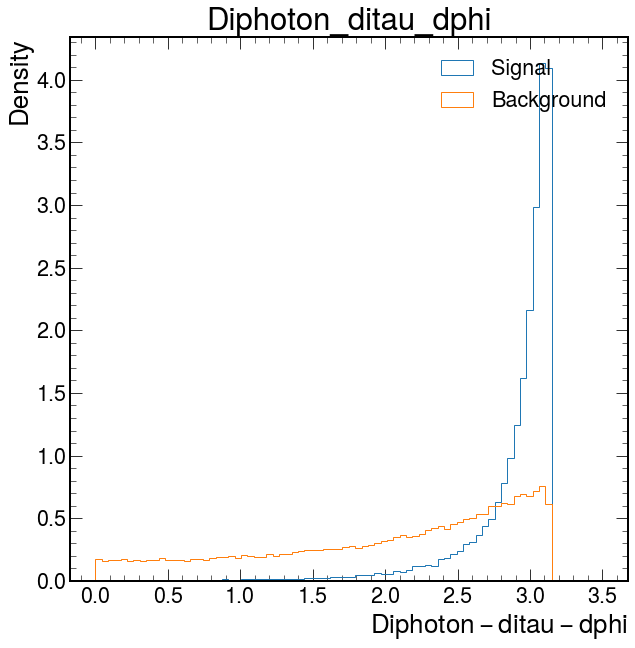

In [127]:
plt.hist(signal.Diphoton_ditau_dphi, bins=80, range=(0, 3.5), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_ditau_dphi, range=(0, 3.5), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$Diphoton-ditau-dphi$")
plt.ylabel(r'Density')
plt.title('Diphoton_ditau_dphi')
plt.savefig("Histogram/Diphoton_ditau_dphi.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


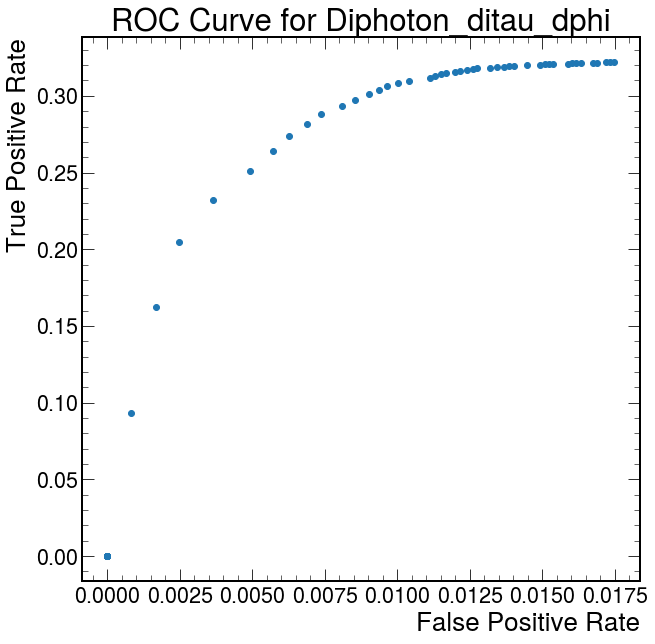

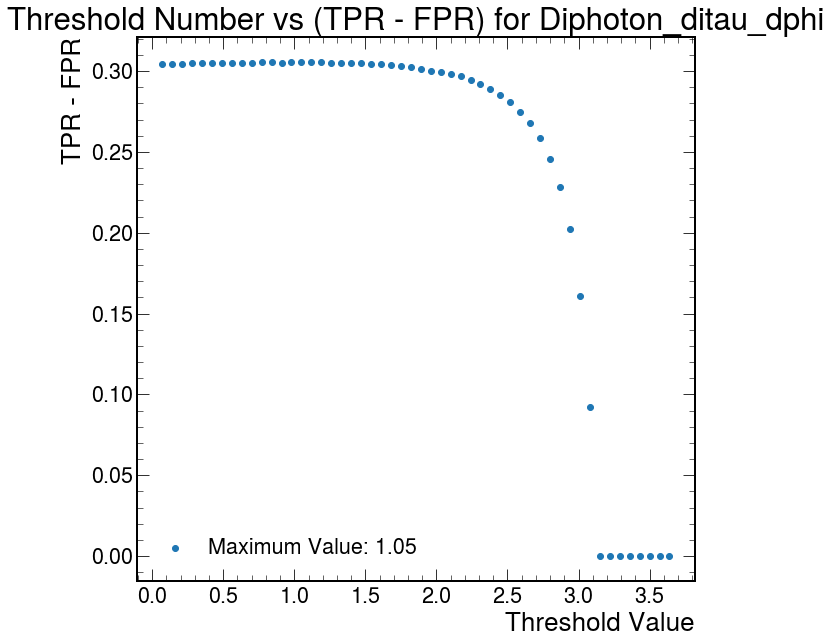

In [128]:
name = 'Diphoton_ditau_dphi'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 3.5))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 3.5))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### dilep_leadpho_mass

#### Data Visualisation

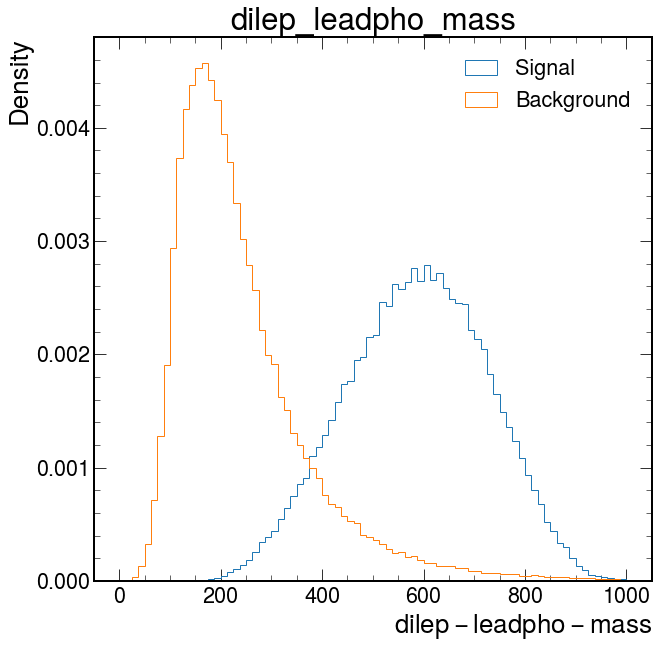

In [129]:
plt.hist(signal.dilep_leadpho_mass, bins=80, range=(0, 1000), histtype="step", label="Signal", density = True)
plt.hist(background.dilep_leadpho_mass, range=(0, 1000), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$dilep-leadpho-mass$")
plt.ylabel(r'Density')
plt.title('dilep_leadpho_mass')
plt.savefig("Histogram/dilep_leadpho_mass.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51


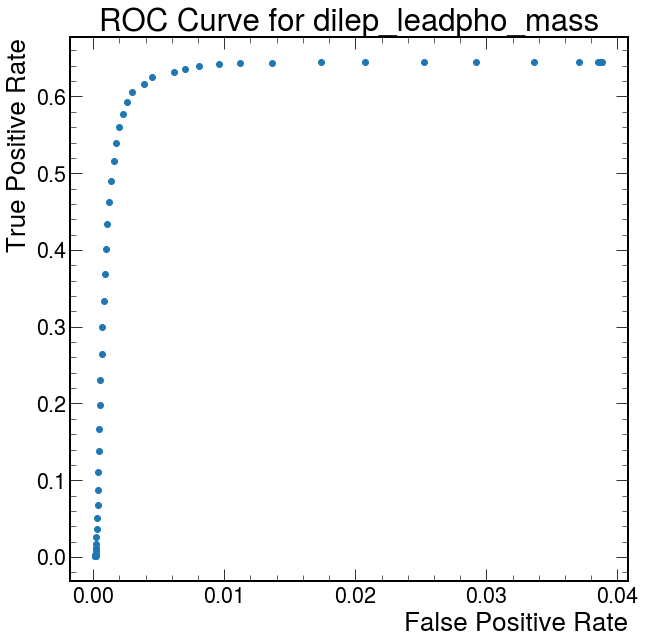

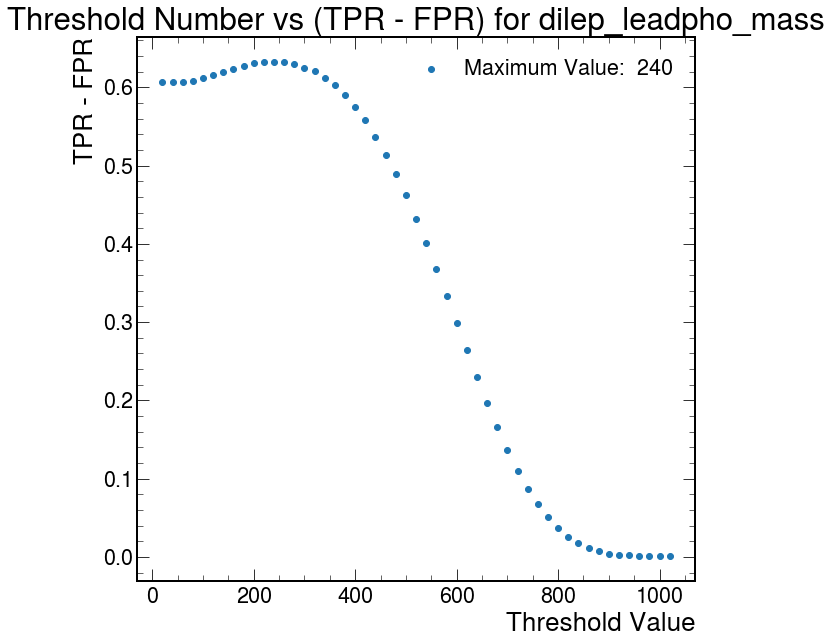

In [130]:
name = 'dilep_leadpho_mass'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 1000))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 1000))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### reco_MX_mgg

#### Data visualisation

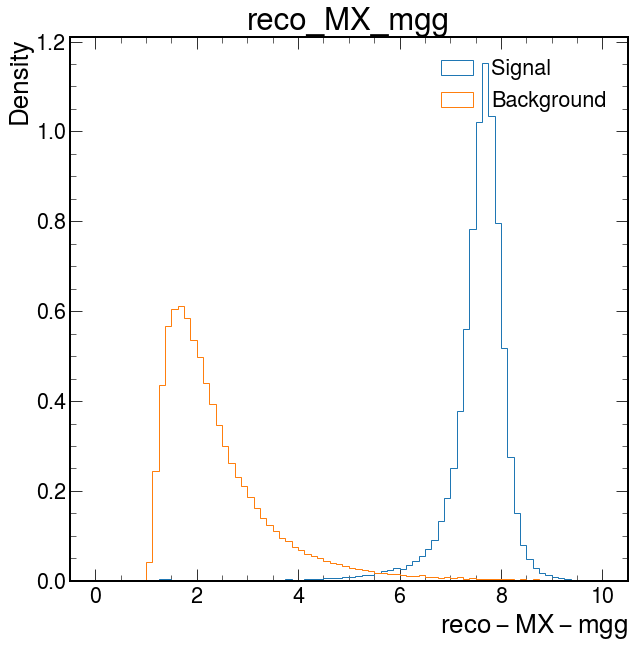

In [132]:
plt.hist(signal.reco_MX_mgg, bins=80, range=(0, 10), histtype="step", label="Signal", density = True)
plt.hist(background.reco_MX_mgg, range=(0, 10), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$reco-MX-mgg$")
plt.ylabel(r'Density')
plt.title('reco_MX_mgg')
plt.savefig("Histogram/reco_MX_mgg.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


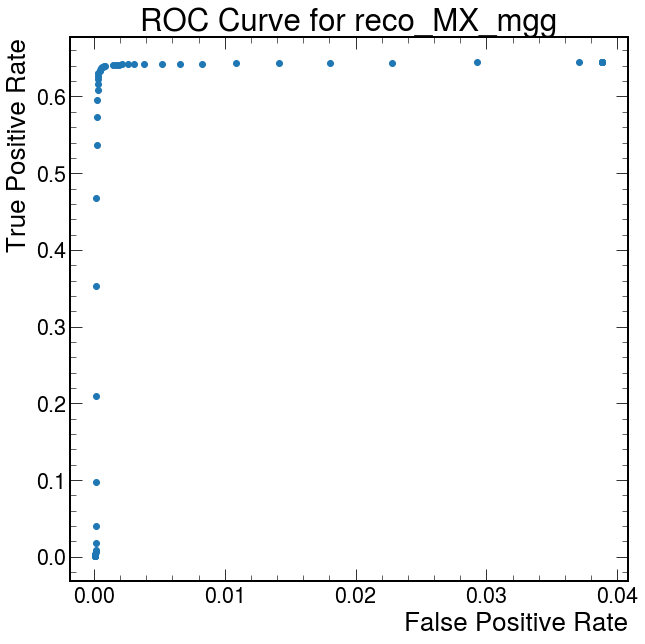

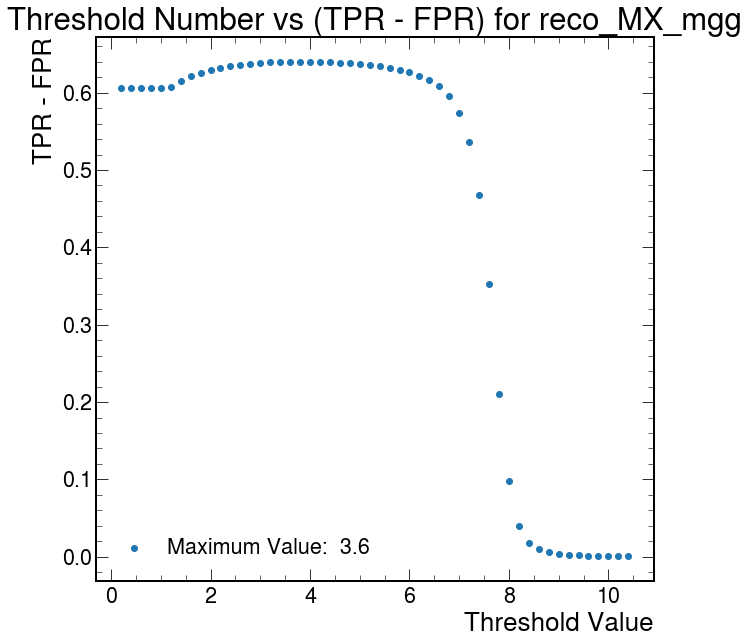

In [133]:
name = 'reco_MX_mgg'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 10))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 10))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Diphoton_ditau_deta

### Data Visualisation

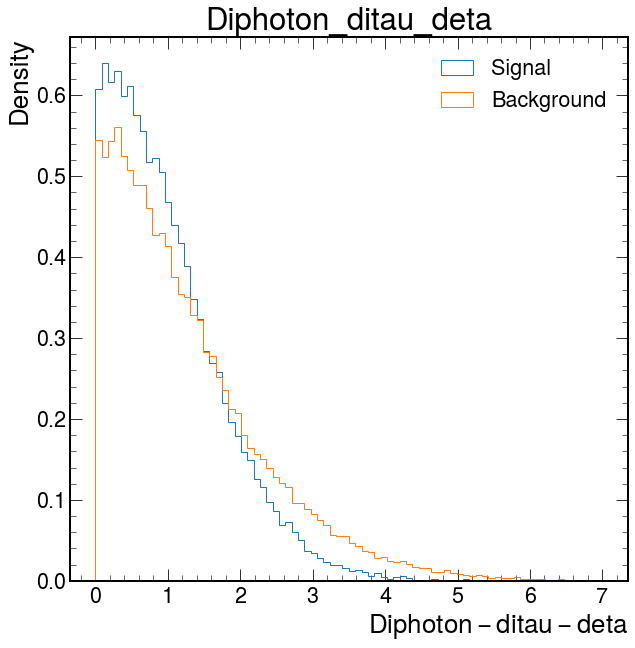

In [134]:
plt.hist(signal.Diphoton_ditau_deta, bins=80, range=(0, 7), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_ditau_deta, range=(0, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$Diphoton-ditau-deta$")
plt.ylabel(r'Density')
plt.title('Diphoton_ditau_deta')
plt.savefig("Histogram/Diphoton_ditau_deta.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


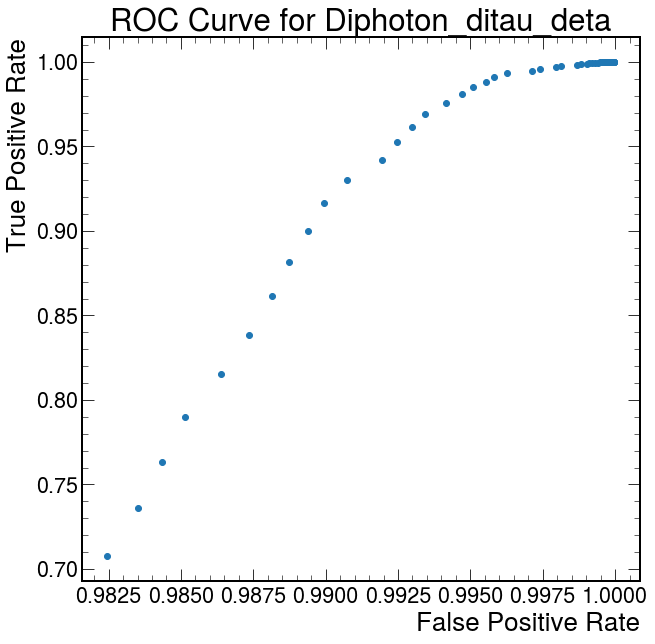

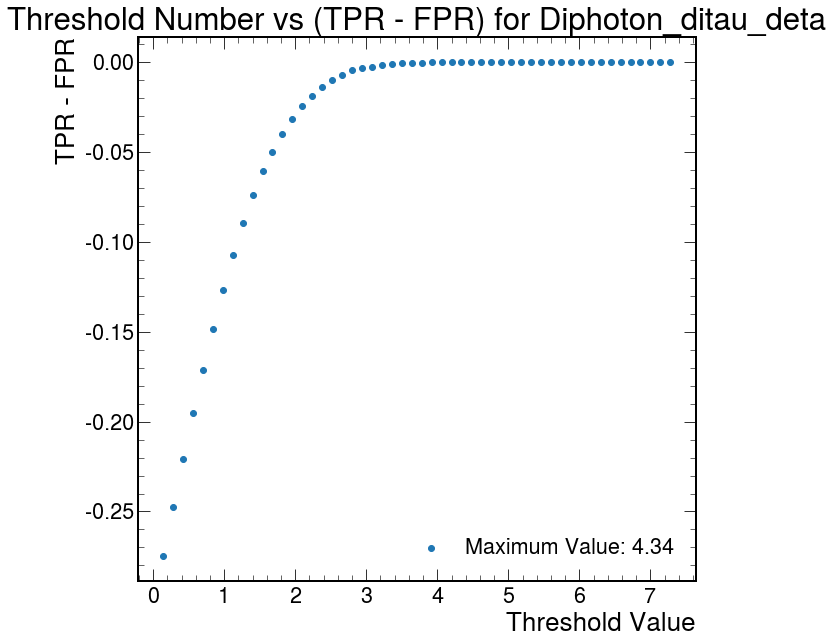

In [136]:
name = 'Diphoton_ditau_deta'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 7))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 7))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Diphoton_lead_lepton_deta

#### Data Visualisation

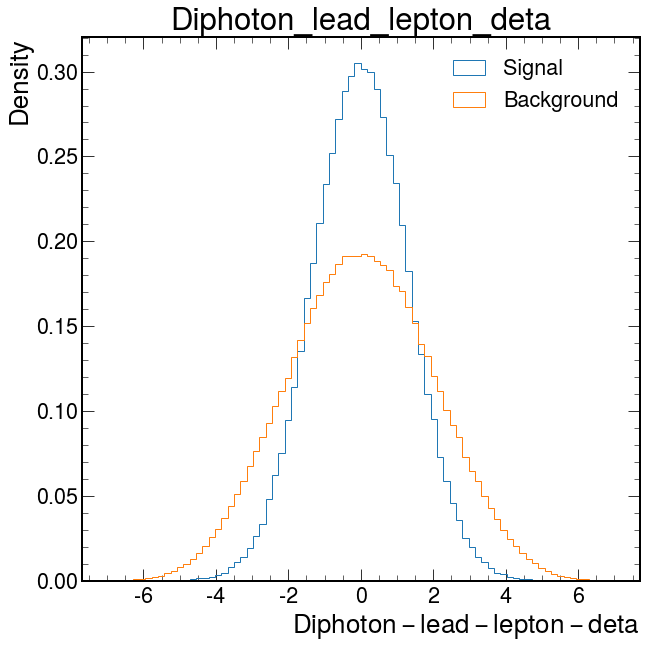

In [142]:
plt.hist(signal.Diphoton_lead_lepton_deta, bins=80, range=(-7, 7), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_lead_lepton_deta, range=(-7, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$Diphoton-lead-lepton-deta$")
plt.ylabel(r'Density')
plt.title('Diphoton_lead_lepton_deta')
plt.savefig("Histogram/Diphoton_lead_lepton_deta.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50


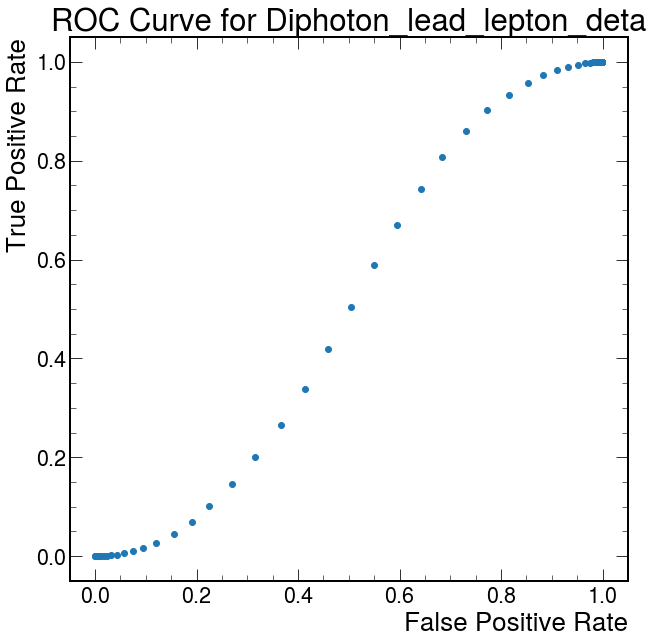

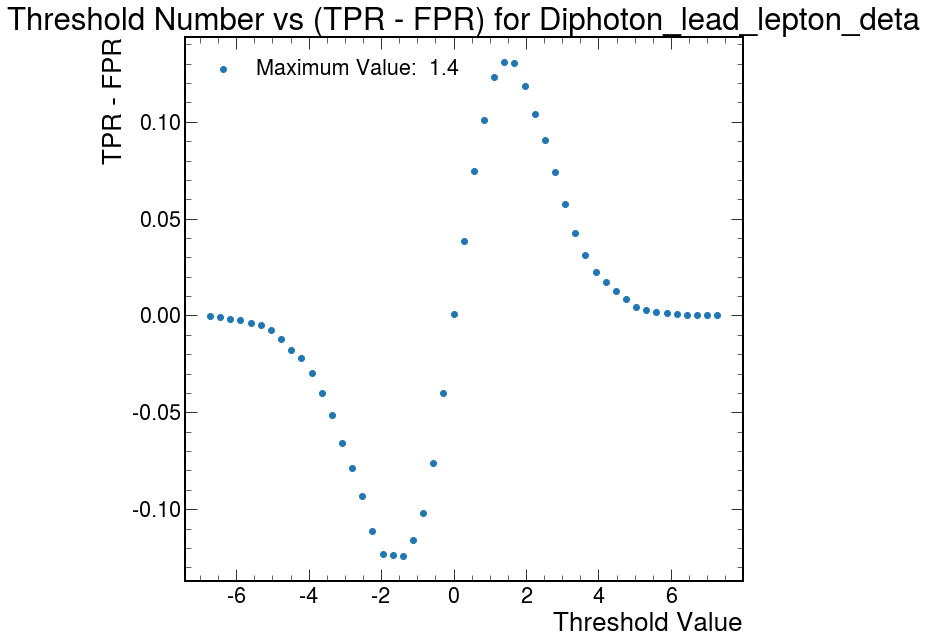

In [143]:
name = 'Diphoton_lead_lepton_deta'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(-7, 7),)
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(-7, 7),)

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Diphoton_lead_lepton_dR
#### Data Visualisation

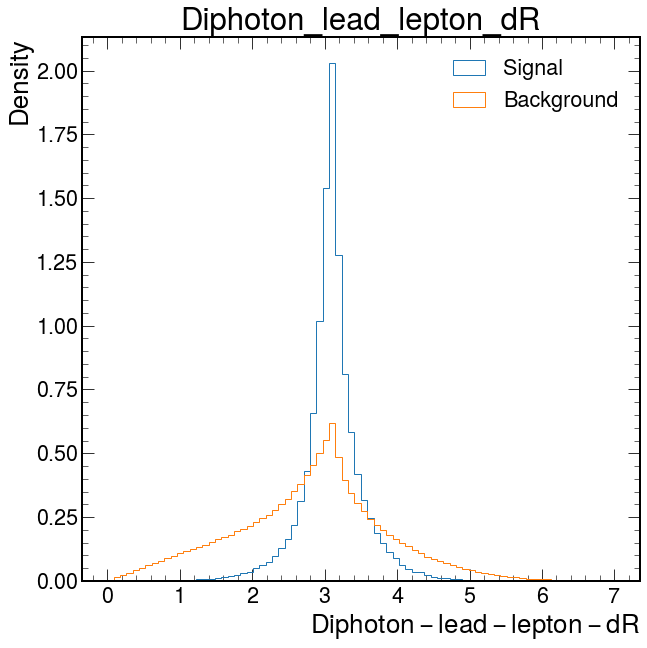

In [140]:
plt.hist(signal.Diphoton_lead_lepton_dR, bins=80, range=(0, 7), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_lead_lepton_dR, range=(0, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$Diphoton-lead-lepton-dR$")
plt.ylabel(r'Density')
plt.title('Diphoton_lead_lepton_dR')
plt.savefig("Histogram/Diphoton_lead_lepton_dR.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


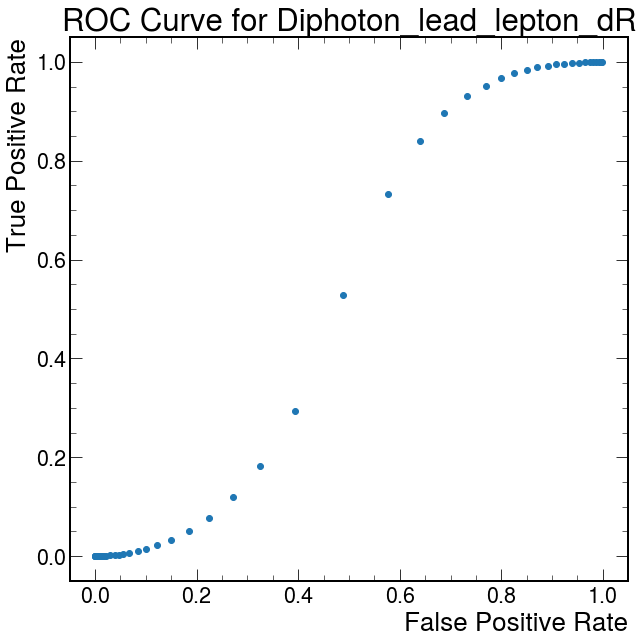

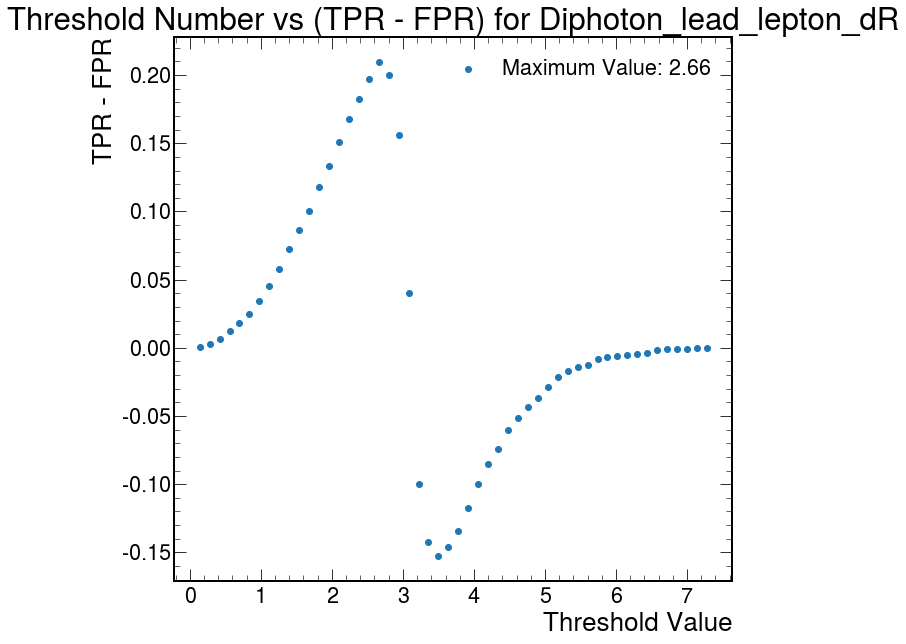

In [144]:
name = 'Diphoton_lead_lepton_dR'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 7))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 7))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Diphoton_sublead_lepton_deta

#### Data Visualisation

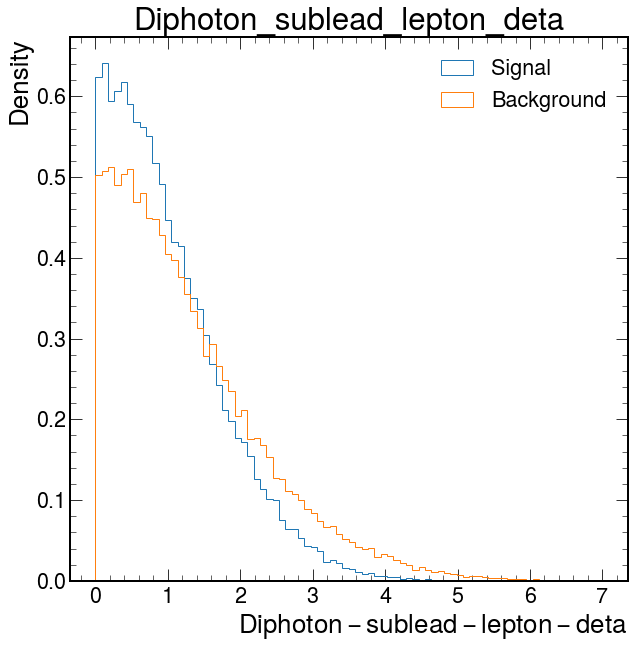

In [145]:
plt.hist(signal.Diphoton_sublead_lepton_deta, bins=80, range=(0, 7), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_sublead_lepton_deta, range=(0, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$Diphoton-sublead-lepton-deta$")
plt.ylabel(r'Density')
plt.title('Diphoton_sublead_lepton_deta')
plt.savefig("Histogram/Diphoton_sublead_lepton_deta.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


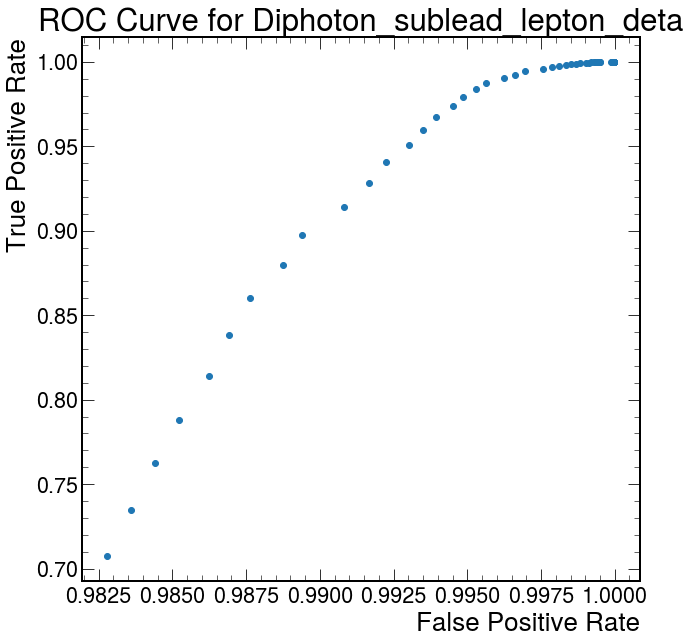

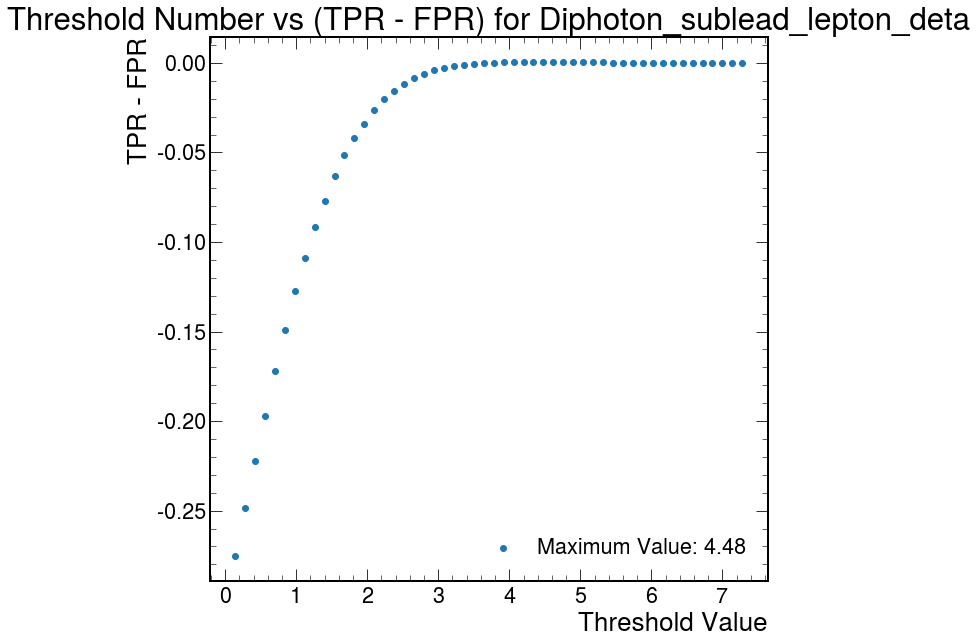

In [146]:
name = 'Diphoton_sublead_lepton_deta'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 7))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 7))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] <= i].weight_central)
    FP = sum(background[background[name] <= i].weight_central)
    FN = sum(signal[signal[name] > i].weight_central)
    TN = sum(background[background[name] > i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Diphoton_sublead_lepton_dR

#### Data Visualisation

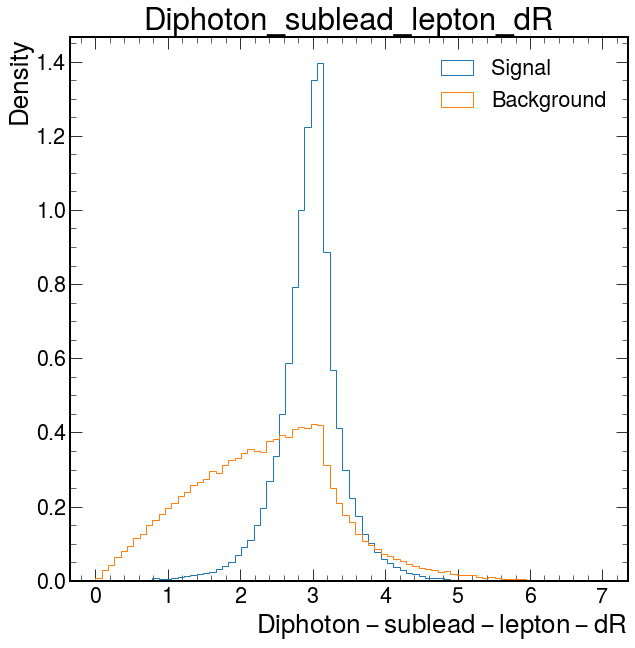

In [147]:
plt.hist(signal.Diphoton_sublead_lepton_dR, bins=80, range=(0, 7), histtype="step", label="Signal", density = True)
plt.hist(background.Diphoton_sublead_lepton_dR, range=(0, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$Diphoton-sublead-lepton-dR$")
plt.ylabel(r'Density')
plt.title('Diphoton_sublead_lepton_dR')
plt.savefig("Histogram/Diphoton_sublead_lepton_dR.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


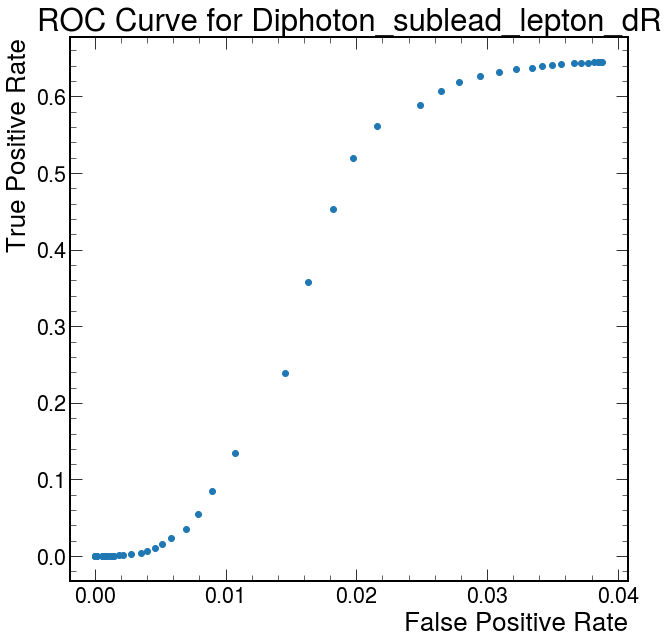

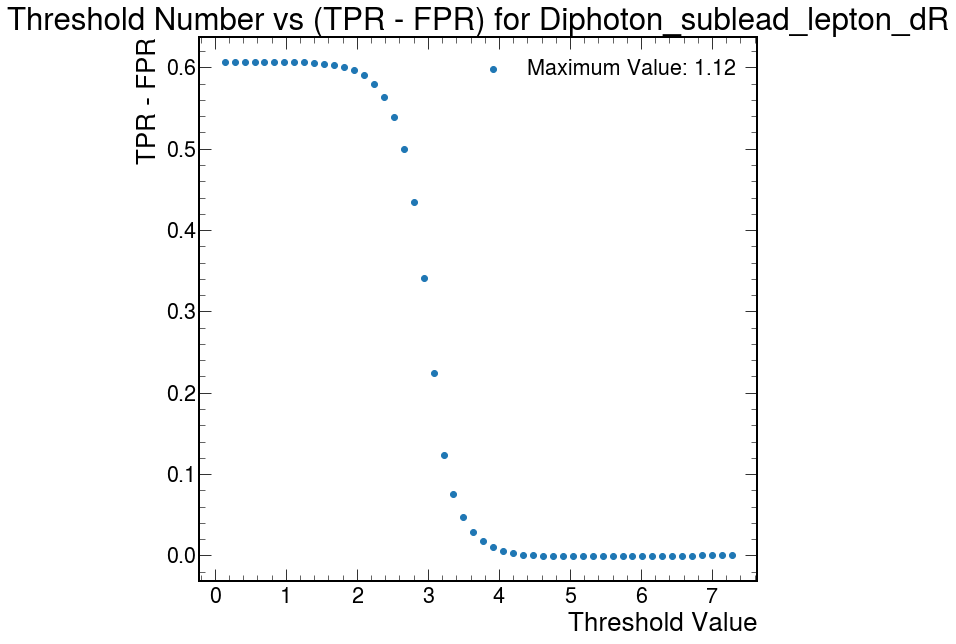

In [148]:
name = 'Diphoton_sublead_lepton_dR'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 7))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 7))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### LeadPhoton_ditau_dR
#### Data Visualisation

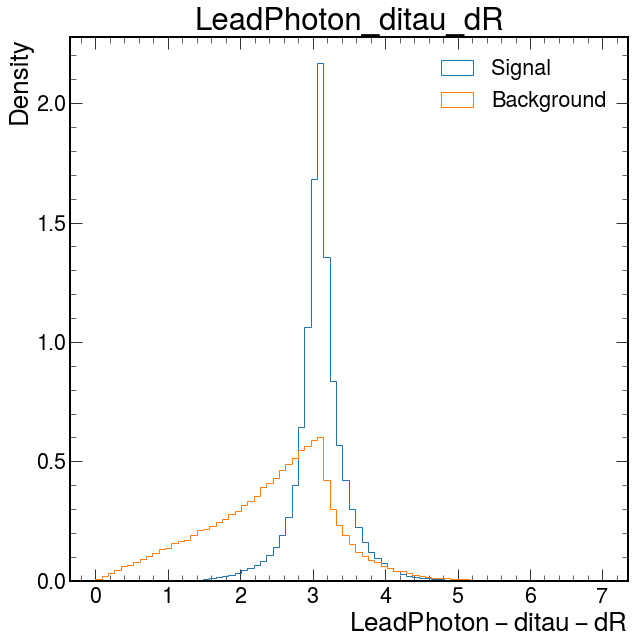

In [149]:
plt.hist(signal.LeadPhoton_ditau_dR, bins=80, range=(0, 7), histtype="step", label="Signal", density = True)
plt.hist(background.LeadPhoton_ditau_dR, range=(0, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$LeadPhoton-ditau-dR$")
plt.ylabel(r'Density')
plt.title('LeadPhoton_ditau_dR')
plt.savefig("Histogram/LeadPhoton_ditau_dR.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


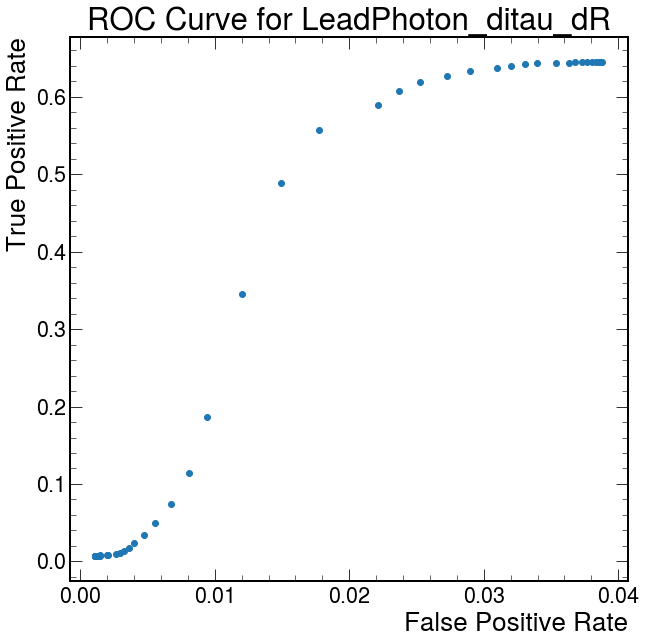

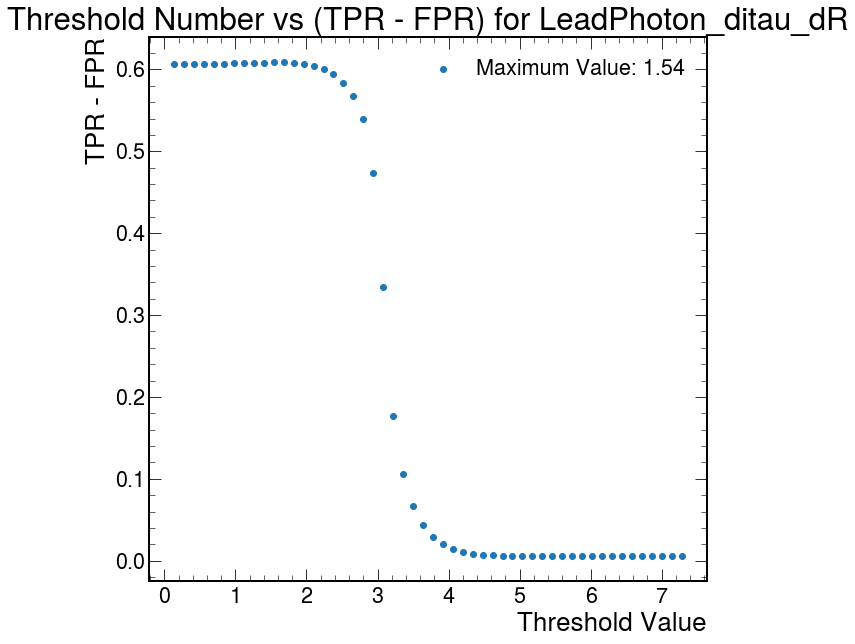

In [150]:
name = 'LeadPhoton_ditau_dR'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 7))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 7))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### LeadPhoton_lead_lepton_dR
#### Data Visualisation

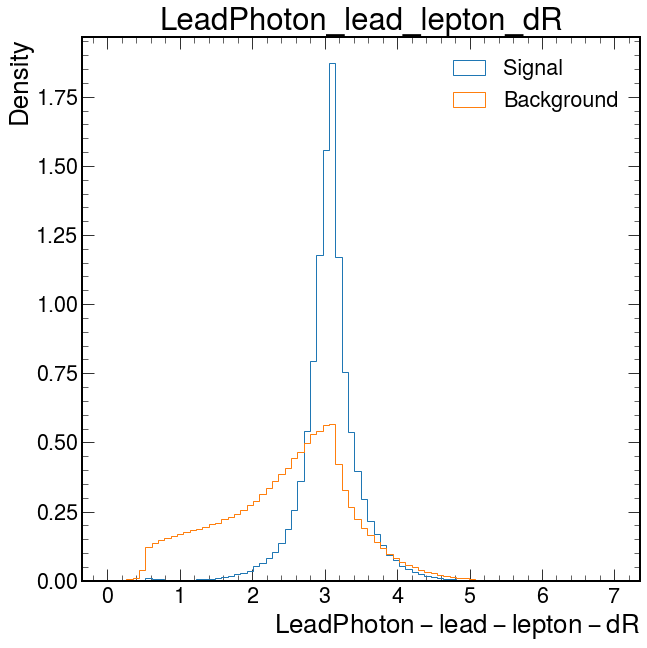

In [151]:
plt.hist(signal.LeadPhoton_lead_lepton_dR, bins=80, range=(0, 7), histtype="step", label="Signal", density = True)
plt.hist(background.LeadPhoton_lead_lepton_dR, range=(0, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$LeadPhoton-lead-lepton-dR$")
plt.ylabel(r'Density')
plt.title('LeadPhoton_lead_lepton_dR')
plt.savefig("Histogram/LeadPhoton_lead_lepton_dR.pdf", format="pdf", bbox_inches="tight")
plt.show()

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


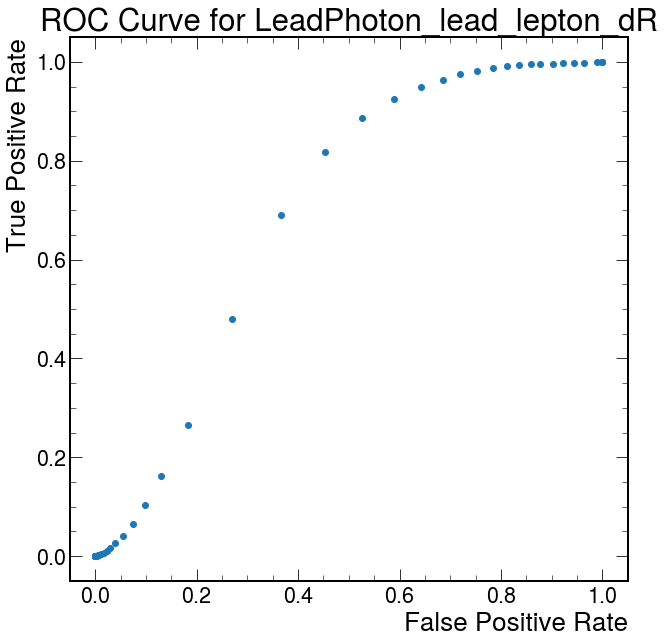

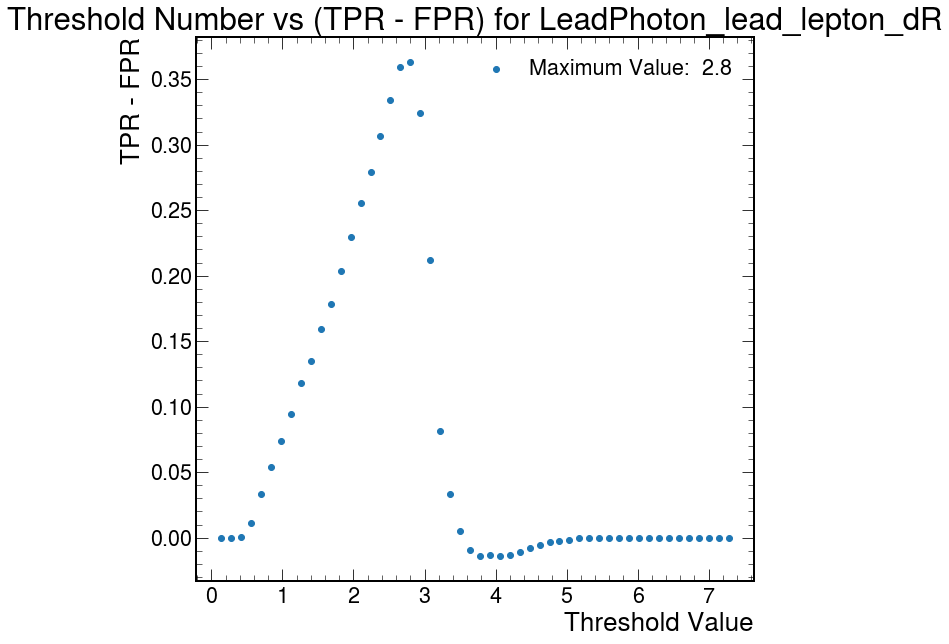

In [161]:
name = 'LeadPhoton_lead_lepton_dR'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 7))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 7))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### SubleadPhoton_lead_lepton_dR

#### Data Visualisation

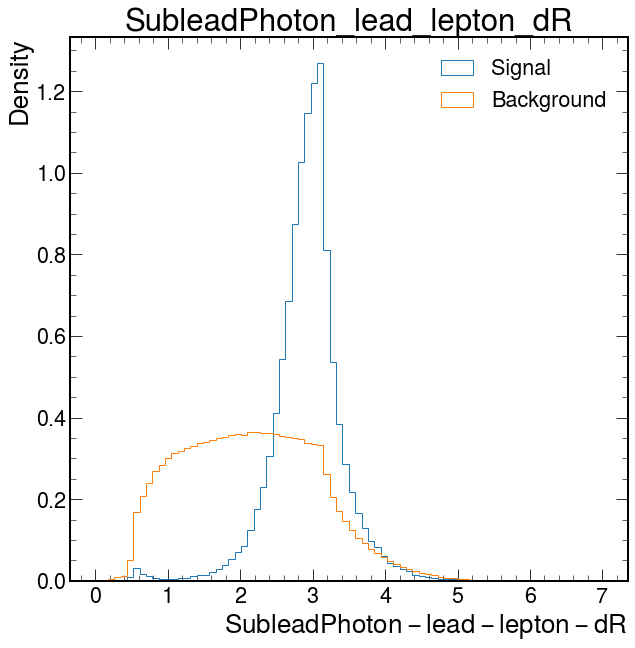

In [162]:
plt.hist(signal.SubleadPhoton_lead_lepton_dR, bins=80, range=(0, 7), histtype="step", label="Signal", density = True)
plt.hist(background.SubleadPhoton_lead_lepton_dR, range=(0, 7), bins=80, histtype="step", label="Background", density = True)
plt.legend()
plt.xlabel(r"$SubleadPhoton-lead-lepton-dR$")
plt.ylabel(r'Density')
plt.title('SubleadPhoton_lead_lepton_dR')
plt.savefig("Histogram/SubleadPhoton_lead_lepton_dR.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Analysis

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
51/50
52/50


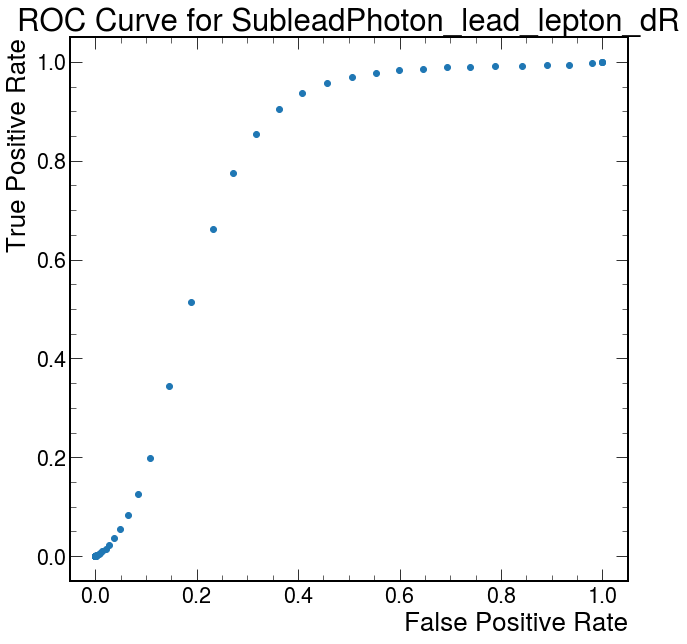

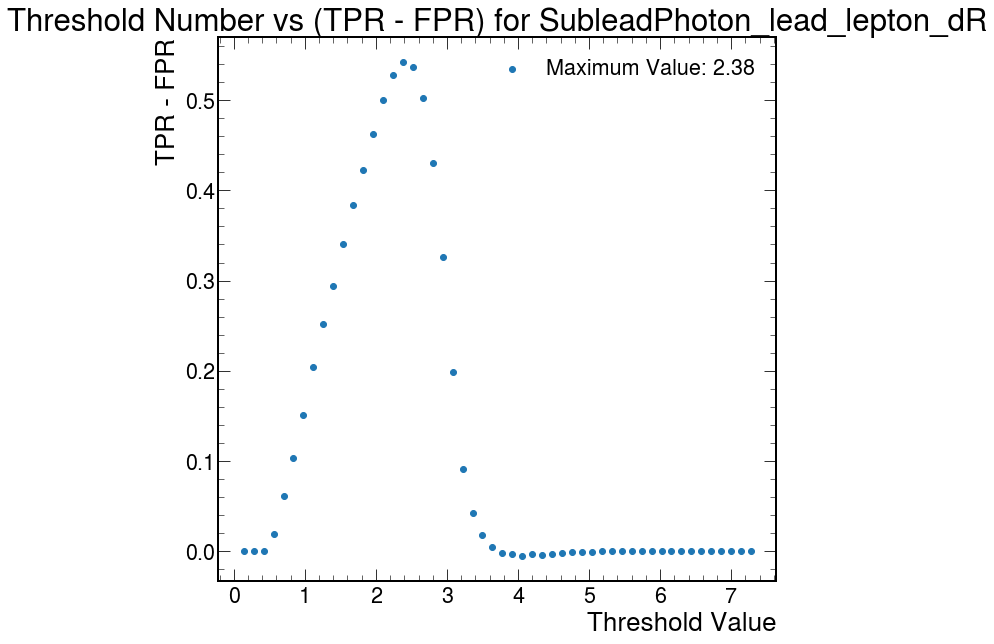

In [163]:
name = 'SubleadPhoton_lead_lepton_dR'

hist_signal, bin_edges_signal = np.histogram(signal[name], bins=80, range=(0, 7))
hist_background, bin_edges_background = np.histogram(background[name], bins=80, range=(0, 7))

#Gets the maximum and minimum edge values
minimum_edge = min(min(bin_edges_signal),min(bin_edges_background))
maximum_edge = max(max(bin_edges_signal),max(bin_edges_background))

#step size for each threshold value (100 steps)
step_number = 50
step_size = (maximum_edge - minimum_edge)/step_number

TPR_arr = []
FPR_arr = []
step_size_arr = []

i = minimum_edge
count = 1

while i < (maximum_edge+step_size):
    print(f'{count}/{int(((maximum_edge-minimum_edge)+step_size)/step_size)}')
    count += 1
    i += step_size
    TP = sum(signal[signal[name] >= i].weight_central)
    FP = sum(background[background[name] >= i].weight_central)
    FN = sum(signal[signal[name] < i].weight_central)
    TN = sum(background[background[name] < i].weight_central)

    TPR = TP/(TP +FN)
    FPR = FP/(FP +TN)
    TPR_arr.append(TPR)
    FPR_arr.append(FPR)
    step_size_arr.append(i)

fig = plt.figure()
plt.scatter(FPR_arr,TPR_arr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.savefig(f"ROC_Curves_Threshold/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig = plt.figure()
diff = np.array(TPR_arr)-np.array(FPR_arr)
max_value = max(diff)
index_ = np.where(diff == max_value)[0][0]
plt.scatter(step_size_arr,diff, label = f'Maximum Value: {step_size_arr[index_]:4g}')
plt.xlabel('Threshold Value')
plt.ylabel('TPR - FPR')
plt.legend()
plt.title(f'Threshold Number vs (TPR - FPR) for {name}')
plt.savefig(f"TPR_FPR_Threshold_Best_Value_Graphs/{name}.pdf", format="pdf", bbox_inches="tight")
plt.show()